# Predicting the Next Year's Energy Demand in Great Britain using XGBoost

## Contents

1. [Importing Libraries & Packages](#1.-Importing-Libraries-&-Packages)  
2. [Pulling the Data](#2.-Pulling-the-Data)  
3. [Examining & Preparing the Data](#3.-Examining-&-Preparing-the-Data) 
4. [Feature Engineering](#4.-Feature-Engineering)
5. [Training the Model](#5.-Training-the-Model)
6. [Evaluating the Model](#6.-Evaluating-the-Model)
7. [Predicting Future Energy Use](#7.-Predicting-Future-Energy-Use)

## 1. Importing Libraries & Packages

Standard step for importing the required libraries and packages. Also setting colour pallette defaults used throughout project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb 
import os
import requests
import re
import shutil
import glob
import holidays

from statsmodels.graphics.tsaplots import plot_acf
from datetime import timedelta, datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

[Back to Contents](#Contents)

## 2. Pulling the Data

The first proper step in our project is to use the NESO API to pull Britain's historical energy demand data. This comes in the form of yearly files that are occasionally changed retrospectively (almost always formatting changes to maintain consistency between years) and so each time we run this step (which definitely won't be every time we tinker with our model!), we will pull all of the yearly data files available.

Before examing our data more thoroughly, we then check that the correct number of years worth of data have been pulled from NESO by referencing the number of files available on their website for manual download (25), that our data is broadly complete by comparing the approximate number of rows we would expect to find with 48 entries a day (demand is recorded in half-hour time frames), and checking that the df has read in correctly with actual data available.

Here we see that at least some of our CSV files contain the relevant data (we aren't just loading in blank files!) and from reading the National Grid's [Demand Data Field Descriptions](https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fraw.githubusercontent.com%2Fmwinterdata%2FUKEnergyDemandXGBoost%2Frefs%2Fheads%2Fmain%2FDemandData%2520Field%2520Descriptions_1.doc&wdOrigin=BROWSELINK) we know that the 'ND' column is what we want to look at for the national energy demand of Great Britain. Also, from the [NESO FAQ](https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fraw.githubusercontent.com%2Fmwinterdata%2FUKEnergyDemandXGBoost%2Frefs%2Fheads%2Fmain%2Ffaq-neso.docx&wdOrigin=BROWSELINK), we know that this is measured in MW, and that it represents the average demand over half-hour period the 'SETTLEMENT_PERIOD' column (rather than say an instantaneous reading on exactly the half-hour). As 'SETTLEMENT_DATE' is fairly self explanatory (although also clarified in the above docs), we can now know that where the 'SETTLEMENT_DATE' is '2001-01-01', the 'SETTLEMENT_PERIOD' is '1', and the 'ND' is '38631', the average energy demand in Great Britain between 00:00am and 00:30am on the January 1st 2001 was 38,631MW. 


In [3]:
# 2.0. Delete folder if it already exists to avoid duplication as when pulling the data we will pull all of the files
#      to ensure that any historical data/formatting changes are accounted for
save_dir = "neso_energy_demand_data"
if os.path.exists(save_dir):
    print(f"Removing existing directory: {save_dir}")
    shutil.rmtree(save_dir)

# 2.1. Re-create the folder
os.makedirs(save_dir, exist_ok=True)

# 2.2. Query NESO API for data package info
api_url = "https://api.neso.energy/api/3/action/datapackage_show?id=historic-demand-data"
response = requests.get(api_url)

if response.status_code != 200:
    raise Exception(f"Failed to retrieve metadata from API: {response.status_code}")

data = response.json()

# 2.3. Extract URLs of CSV files
resources = data.get("result", {}).get("resources", [])
csv_resources = {
    res["name"]: res["path"]
    for res in resources
    if res.get("path", "").endswith(".csv")
}

# 2.4. Download each year's CSV file
for name, url in csv_resources.items():
    # Normalize filename
    filename = re.sub(r"[^\w\d_]+", "_", name.lower()) + ".csv"
    save_path = os.path.join(save_dir, filename)

    print(f"Downloading {filename} from {url}...")
    try:
        file_response = requests.get(url)
        file_response.raise_for_status()
        with open(save_path, "wb") as f:
            f.write(file_response.content)
    except Exception as e:
        print(f"Failed to download {name}: {e}")

print(f"\n Download complete. Files saved to '{save_dir}'")

Removing existing directory: neso_energy_demand_data

 Download complete. Files saved to 'neso_energy_demand_data'


In [4]:
# Path to directory containing CSVs
folder_path = 'neso_energy_demand_data'

# Get a list of all CSV file paths in the directory
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Read and concatenate all CSVs into one DataFrame
df_list = [pd.read_csv(file).assign(source=os.path.basename(file)) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Sense checking no. files & rows

#day_of_year = today.timetuple().tm_yday
#approx_rows_expected = int(48 * 365.25 * 24) + int(48 * day_of_year) # no. half hour periods in a day x avg. days in a year x no. years of data 
print(f"Loaded {len(csv_files)} CSV files.")
print(f"Rows in combined CSV file: {len(df):,}")
#print(f"Approximate number of rows expected : {approx_rows_expected:,}")

Loaded 25 CSV files.
Rows in combined CSV file: 430,510


In [5]:
df.head()

SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND  TSD  ENGLAND_WALES_DEMAND  \
0      2001-01-01                  1  38631  NaN                 34060   
1      2001-01-01                  2  39808  NaN                 35370   
2      2001-01-01                  3  40039  NaN                 35680   
3      2001-01-01                  4  39339  NaN                 35029   
4      2001-01-01                  5  38295  NaN                 34047   

   EMBEDDED_WIND_GENERATION  EMBEDDED_WIND_CAPACITY  \
0                       NaN                     NaN   
1                       NaN                     NaN   
2                       NaN                     NaN   
3                       NaN                     NaN   
4                       NaN                     NaN   

   EMBEDDED_SOLAR_GENERATION  EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  ...  \
0                        NaN                      NaN            0  ...   
1                        NaN                      NaN            0  ...   
2                        NaN                      NaN            0  ...   
3                        NaN                      NaN            0  ...   
4                        NaN                      NaN            0  ...   

   IFA2_FLOW  BRITNED_FLOW  MOYLE_FLOW  EAST_WEST_FLOW  NEMO_FLOW  NSL_FLOW  \
0        NaN           NaN         NaN             NaN        NaN       NaN   
1        NaN           NaN         NaN             NaN        NaN       NaN   
2        NaN           NaN         NaN             NaN        NaN       NaN   
3        NaN           NaN         NaN             NaN        NaN       NaN   
4        NaN           NaN         NaN             NaN        NaN       NaN   

   ELECLINK_FLOW  VIKING_FLOW  GREENLINK_FLOW                         source  
0            NaN          NaN             NaN  historic_demand_data_2001.csv  
1            NaN          NaN             NaN  historic_demand_data_2001.csv  
2            NaN          NaN             NaN  historic_demand_data_2001.csv  
3            NaN          NaN             NaN  historic_demand_data_2001.csv  
4            NaN          NaN             NaN  historic_demand_data_2001.csv  

[5 rows x 23 columns]

In [6]:
df.tail()

SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND      TSD  \
430505      2025-07-22                 44  26499  28448.0   
430506      2025-07-22                 45  25492  27483.0   
430507      2025-07-22                 46  24543  26469.0   
430508      2025-07-22                 47  23637  25384.0   
430509      2025-07-22                 48  22323  23896.0   

        ENGLAND_WALES_DEMAND  EMBEDDED_WIND_GENERATION  \
430505                 24496                     892.0   
430506                 23487                     882.0   
430507                 22611                     872.0   
430508                 21821                     829.0   
430509                 20608                     785.0   

        EMBEDDED_WIND_CAPACITY  EMBEDDED_SOLAR_GENERATION  \
430505                  6606.0                        0.0   
430506                  6606.0                        0.0   
430507                  6606.0                        0.0   
430508                  6606.0                        0.0   
430509                  6606.0                        0.0   

        EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  ...  IFA2_FLOW  BRITNED_FLOW  \
430505                  19451.0            0  ...      915.0         733.0   
430506                  19451.0            0  ...      742.0         974.0   
430507                  19451.0            0  ...      722.0         992.0   
430508                  19451.0            0  ...      429.0         899.0   
430509                  19451.0            0  ...      405.0         892.0   

        MOYLE_FLOW  EAST_WEST_FLOW  NEMO_FLOW  NSL_FLOW  ELECLINK_FLOW  \
430505      -450.0          -480.0      563.0    1395.0          706.0   
430506      -450.0          -522.0      384.0    1395.0          606.0   
430507      -450.0          -457.0      373.0    1395.0          596.0   
430508      -386.0          -342.0      925.0    1395.0          534.0   
430509      -364.0          -190.0      967.0    1395.0          529.0   

        VIKING_FLOW  GREENLINK_FLOW                         source  
430505        791.0          -514.0  historic_demand_data_2025.csv  
430506        801.0          -514.0  historic_demand_data_2025.csv  
430507        810.0          -514.0  historic_demand_data_2025.csv  
430508       1343.0          -514.0  historic_demand_data_2025.csv  
430509       1393.0          -514.0  historic_demand_data_2025.csv  

[5 rows x 23 columns]

[Back to Contents](#Contents)

# 3. Examining & Preparing the Data

Now that we have pulled our data and checked it is passing top level sense checks in its raw form, we want to make it a bit more user friendly and then examine it in detail. The first thing to note (apart from all the columns we don't need!), is that as explained in the [NESO FAQ](https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fraw.githubusercontent.com%2Fmwinterdata%2FUKEnergyDemandXGBoost%2Frefs%2Fheads%2Fmain%2Ffaq-neso.docx&wdOrigin=BROWSELINK) referenced above, all of the 'SETTLEMENT_PERIOD' values represent a half hour segment in UK local time. As the clocks in the UK go forward an hour in March, and back an hour in October, we may run into some formatting issues. 

This would be a minor issue and could affect our model in any circumstance, but it is a particularly big problem as the data we have pulled from the [NESO website](https://www.neso.energy/data-portal/historic-demand-data?page=1) only has a 'SETTLEMENT_DATE' column, with no exact time value, but instead relies on the 'SETTLEMENT_PERIOD' column as a substitute for this.    

In [7]:
df_clocks_back = df.loc[df['SETTLEMENT_PERIOD'] > 48]

print(df_clocks_back[['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD']].head(10))

      SETTLEMENT_DATE  SETTLEMENT_PERIOD
14446      2001-10-28                 49
14447      2001-10-28                 50
31918      2002-10-27                 49
31919      2002-10-27                 50
49390      2003-10-26                 49
49391      2003-10-26                 50
67198      2004-10-31                 49
67199      2004-10-31                 50
84670      2005-10-30                 49
84671      2005-10-30                 50


In [8]:
def build_settlement_datetime(
    df,
    date_col='SETTLEMENT_DATE',
    period_col='SETTLEMENT_PERIOD',
    set_index=True,
    add_dst_columns=True
):
    out = df.copy()

    # Ensure date is date-only (no time component)
    out[date_col] = pd.to_datetime(out[date_col]).dt.normalize()

    # 46/48/50 periods per day
    periods_per_day = out.groupby(out[date_col])[period_col].transform('max')
    p = pd.to_numeric(out[period_col], errors='coerce').astype('Int64')

    # Base minutes from midnight
    base_min = (p - 1) * 30

    # Adjust for clock changes (GB electricity market convention)
    adj_min = np.where(
        (periods_per_day == 50) & (p >= 5), base_min - 60,      # fall-back: duplicate hour
        np.where((periods_per_day == 46) & (p >= 3), base_min + 60,  # spring-forward: missing hour
                 base_min)
    )

    # Build naive local wall-clock datetimes
    dt_local_naive = out[date_col] + pd.to_timedelta(adj_min, unit='m')

    # Localize to Europe/London (handle DST transitions robustly)
    dt_local = pd.DatetimeIndex(dt_local_naive).tz_localize(
        'Europe/London', ambiguous='infer', nonexistent='shift_forward'
    )

    # Keep local time as a column
    out['SETTLEMENT_DATETIME_LOCAL'] = dt_local

    # Also create UTC version for index
    dt_utc = dt_local.tz_convert('UTC')
    out['SETTLEMENT_DATETIME_UTC'] = dt_utc

    if add_dst_columns:
        # Abbreviation: 'GMT' or 'BST'
        tz_abbrev = pd.Index(dt_local).map(lambda ts: ts.tzname())
        out['TZ_ABBREV'] = tz_abbrev
        
        # Boolean flag for Daylight Saving Time (BST = 1, GMT = 0)
        is_dst = pd.Index(dt_local).map(lambda ts: ts.dst() is not None and ts.dst().total_seconds() != 0)
        out['IS_DST'] = is_dst.astype(int)

        # Numeric UTC offset in hours (0 for GMT, 1 for BST)
        utc_offset_hours = pd.Index(dt_local).map(lambda ts: ts.utcoffset().total_seconds() / 3600.0)
        out['UTC_OFFSET_HOURS'] = utc_offset_hours.astype(float)

    # Set UTC datetime as index
    if set_index:
        out = out.set_index('SETTLEMENT_DATETIME_UTC')

    return out

In [9]:
df = build_settlement_datetime(df, 'SETTLEMENT_DATE', 'SETTLEMENT_PERIOD')
df = df.sort_index()

# sense checks
print(df.index.dtype)          # should show datetime64[ns, UTC]
print(df.index.is_unique)      # should be True

datetime64[ns, UTC]
True


In [10]:
df_clocks_back_check = df.loc[(df.index > '2001-10-27 22:00') & (df.index < '2001-10-28 03:00')][['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD', 'ND']]

print(df_clocks_back_check)

                          SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND
SETTLEMENT_DATETIME_UTC                                            
2001-10-27 22:30:00+00:00      2001-10-27                 48  30189
2001-10-27 23:00:00+00:00      2001-10-28                  1  28656
2001-10-27 23:30:00+00:00      2001-10-28                  2  27877
2001-10-28 00:00:00+00:00      2001-10-28                  3  28412
2001-10-28 00:30:00+00:00      2001-10-28                  4  29174
2001-10-28 01:00:00+00:00      2001-10-28                  5  28546
2001-10-28 01:30:00+00:00      2001-10-28                  6  27867
2001-10-28 02:00:00+00:00      2001-10-28                  7  27166
2001-10-28 02:30:00+00:00      2001-10-28                  8  26920


In [11]:
df_clocks_forward_check = df.loc[(df.index > '2001-03-24 22:00') & (df.index < '2001-03-25 03:00')][['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD', 'ND']]

print(df_clocks_forward_check)

                          SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND
SETTLEMENT_DATETIME_UTC                                            
2001-03-24 22:30:00+00:00      2001-03-24                 46  37023
2001-03-24 23:00:00+00:00      2001-03-24                 47  35645
2001-03-24 23:30:00+00:00      2001-03-24                 48  35263
2001-03-25 00:00:00+00:00      2001-03-25                  1  36148
2001-03-25 00:30:00+00:00      2001-03-25                  2  36859
2001-03-25 01:00:00+00:00      2001-03-25                  3  37397
2001-03-25 01:30:00+00:00      2001-03-25                  4  37301
2001-03-25 02:00:00+00:00      2001-03-25                  5  36673
2001-03-25 02:30:00+00:00      2001-03-25                  6  36323


In [12]:
df_issue_highlighting = df.loc[(df.index > '2001-07-25 21:00') & (df.index < '2001-07-26 02:00')][['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD', 'ND']]

print(df_issue_highlighting)

                          SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND
SETTLEMENT_DATETIME_UTC                                            
2001-07-25 21:30:00+00:00      2001-07-25                 46  33736
2001-07-25 22:00:00+00:00      2001-07-25                 47  31398
2001-07-25 22:30:00+00:00      2001-07-25                 48  29322
2001-07-25 23:00:00+00:00      2001-07-26                  1  27613
2001-07-25 23:30:00+00:00      2001-07-26                  2  26726
2001-07-26 00:00:00+00:00      2001-07-26                  3  26437
2001-07-26 00:30:00+00:00      2001-07-26                  4  26166
2001-07-26 01:00:00+00:00      2001-07-26                  5  25831
2001-07-26 01:30:00+00:00      2001-07-26                  6  25296


In [13]:
df.head()

SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND  TSD  \
SETTLEMENT_DATETIME_UTC                                                    
2001-01-01 00:00:00+00:00      2001-01-01                  1  38631  NaN   
2001-01-01 00:30:00+00:00      2001-01-01                  2  39808  NaN   
2001-01-01 01:00:00+00:00      2001-01-01                  3  40039  NaN   
2001-01-01 01:30:00+00:00      2001-01-01                  4  39339  NaN   
2001-01-01 02:00:00+00:00      2001-01-01                  5  38295  NaN   

                           ENGLAND_WALES_DEMAND  EMBEDDED_WIND_GENERATION  \
SETTLEMENT_DATETIME_UTC                                                     
2001-01-01 00:00:00+00:00                 34060                       NaN   
2001-01-01 00:30:00+00:00                 35370                       NaN   
2001-01-01 01:00:00+00:00                 35680                       NaN   
2001-01-01 01:30:00+00:00                 35029                       NaN   
2001-01-01 02:00:00+00:00                 34047                       NaN   

                           EMBEDDED_WIND_CAPACITY  EMBEDDED_SOLAR_GENERATION  \
SETTLEMENT_DATETIME_UTC                                                        
2001-01-01 00:00:00+00:00                     NaN                        NaN   
2001-01-01 00:30:00+00:00                     NaN                        NaN   
2001-01-01 01:00:00+00:00                     NaN                        NaN   
2001-01-01 01:30:00+00:00                     NaN                        NaN   
2001-01-01 02:00:00+00:00                     NaN                        NaN   

                           EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  ...  \
SETTLEMENT_DATETIME_UTC                                          ...   
2001-01-01 00:00:00+00:00                      NaN            0  ...   
2001-01-01 00:30:00+00:00                      NaN            0  ...   
2001-01-01 01:00:00+00:00                      NaN            0  ...   
2001-01-01 01:30:00+00:00                      NaN            0  ...   
2001-01-01 02:00:00+00:00                      NaN            0  ...   

                           NEMO_FLOW  NSL_FLOW  ELECLINK_FLOW  VIKING_FLOW  \
SETTLEMENT_DATETIME_UTC                                                      
2001-01-01 00:00:00+00:00        NaN       NaN            NaN          NaN   
2001-01-01 00:30:00+00:00        NaN       NaN            NaN          NaN   
2001-01-01 01:00:00+00:00        NaN       NaN            NaN          NaN   
2001-01-01 01:30:00+00:00        NaN       NaN            NaN          NaN   
2001-01-01 02:00:00+00:00        NaN       NaN            NaN          NaN   

                           GREENLINK_FLOW                         source  \
SETTLEMENT_DATETIME_UTC                                                    
2001-01-01 00:00:00+00:00             NaN  historic_demand_data_2001.csv   
2001-01-01 00:30:00+00:00             NaN  historic_demand_data_2001.csv   
2001-01-01 01:00:00+00:00             NaN  historic_demand_data_2001.csv   
2001-01-01 01:30:00+00:00             NaN  historic_demand_data_2001.csv   
2001-01-01 02:00:00+00:00             NaN  historic_demand_data_2001.csv   

                           SETTLEMENT_DATETIME_LOCAL  TZ_ABBREV  IS_DST  \
SETTLEMENT_DATETIME_UTC                                                   
2001-01-01 00:00:00+00:00  2001-01-01 00:00:00+00:00        GMT       0   
2001-01-01 00:30:00+00:00  2001-01-01 00:30:00+00:00        GMT       0   
2001-01-01 01:00:00+00:00  2001-01-01 01:00:00+00:00        GMT       0   
2001-01-01 01:30:00+00:00  2001-01-01 01:30:00+00:00        GMT       0   
2001-01-01 02:00:00+00:00  2001-01-01 02:00:00+00:00        GMT       0   

                           UTC_OFFSET_HOURS  
SETTLEMENT_DATETIME_UTC                      
2001-01-01 00:00:00+00:00               0.0  
2001-01-01 00:30:00+00:00               0.0  
2001-01-01 01:00:00+00:00               0.0  
2001-01-01 01:30:00+00:00               0.0  
2001-

In [14]:
df = df[['ND', 'SETTLEMENT_DATETIME_LOCAL', 'IS_DST']]

In [15]:
df.head()

ND SETTLEMENT_DATETIME_LOCAL  IS_DST
SETTLEMENT_DATETIME_UTC                                           
2001-01-01 00:00:00+00:00  38631 2001-01-01 00:00:00+00:00       0
2001-01-01 00:30:00+00:00  39808 2001-01-01 00:30:00+00:00       0
2001-01-01 01:00:00+00:00  40039 2001-01-01 01:00:00+00:00       0
2001-01-01 01:30:00+00:00  39339 2001-01-01 01:30:00+00:00       0
2001-01-01 02:00:00+00:00  38295 2001-01-01 02:00:00+00:00       0

In [16]:
df.tail()

ND SETTLEMENT_DATETIME_LOCAL  IS_DST
SETTLEMENT_DATETIME_UTC                                           
2025-07-22 20:30:00+00:00  26499 2025-07-22 21:30:00+01:00       1
2025-07-22 21:00:00+00:00  25492 2025-07-22 22:00:00+01:00       1
2025-07-22 21:30:00+00:00  24543 2025-07-22 22:30:00+01:00       1
2025-07-22 22:00:00+00:00  23637 2025-07-22 23:00:00+01:00       1
2025-07-22 22:30:00+00:00  22323 2025-07-22 23:30:00+01:00       1

In [17]:
df['ND'].isnull().any()

False

In [18]:
# Boolean mask of which index entries are duplicates
mask = df.index.duplicated(keep=False)

# Show only the duplicate rows
duplicates = df[mask]

# See just the duplicate index values (unique)
duplicate_times = df.index[df.index.duplicated()].unique()

print("Duplicate timestamps found:", len(duplicate_times))
print(duplicate_times)

Duplicate timestamps found: 0
DatetimeIndex([], dtype='datetime64[ns, UTC]', name='SETTLEMENT_DATETIME_UTC', freq=None)


<Axes: title={'center': 'Great Britain National Demand in MW'}, xlabel='Date', ylabel='MW'>

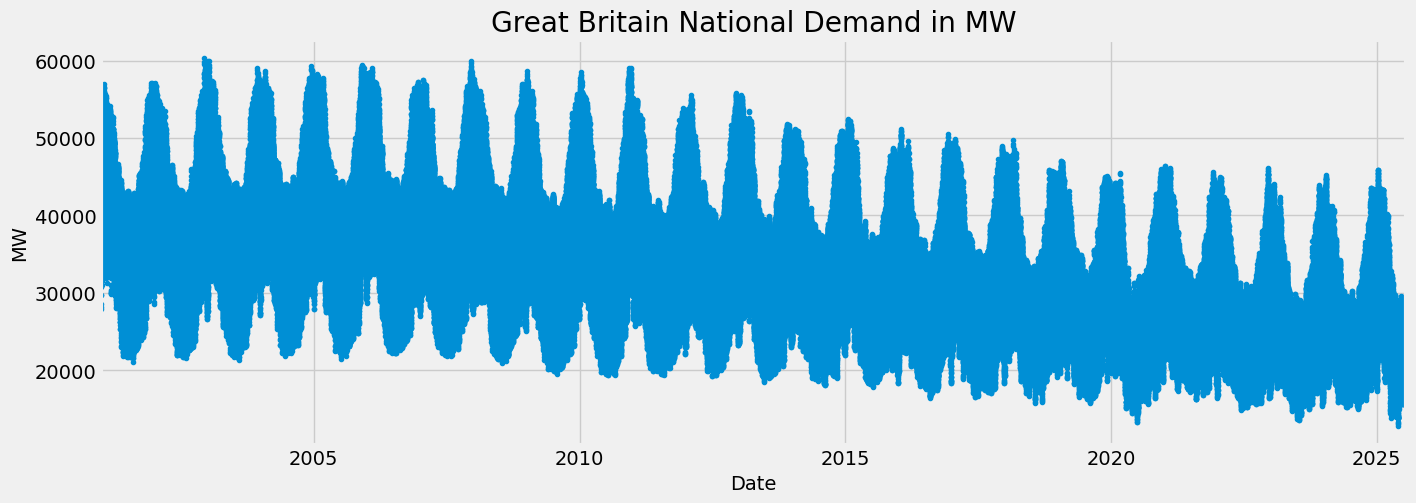

In [19]:
df['ND'].plot(style='.', 
        figsize=(15, 5), 
        color = color_pal[0], 
        title = 'Great Britain National Demand in MW', 
        xlabel = 'Date',
        ylabel = 'MW'
       )

Text(0, 0.5, 'Frequency')

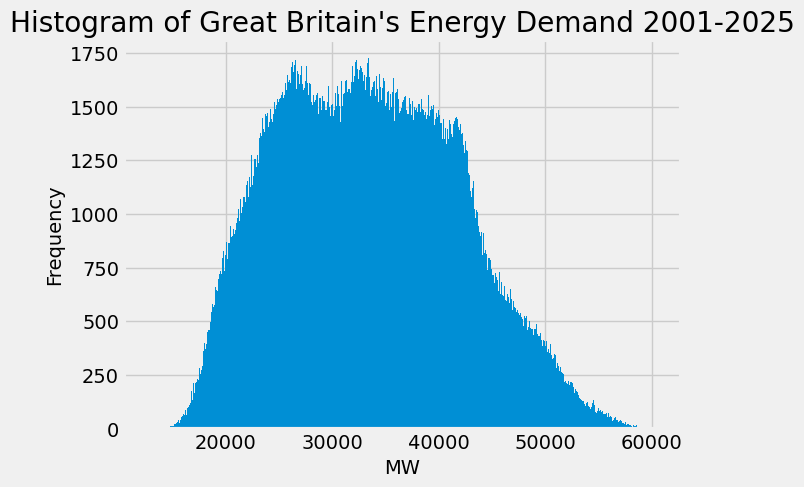

In [20]:
df['ND'].plot(kind='hist', bins=500, title="Histogram of Great Britain's Energy Demand 2001-2025")
plt.xlabel('MW')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

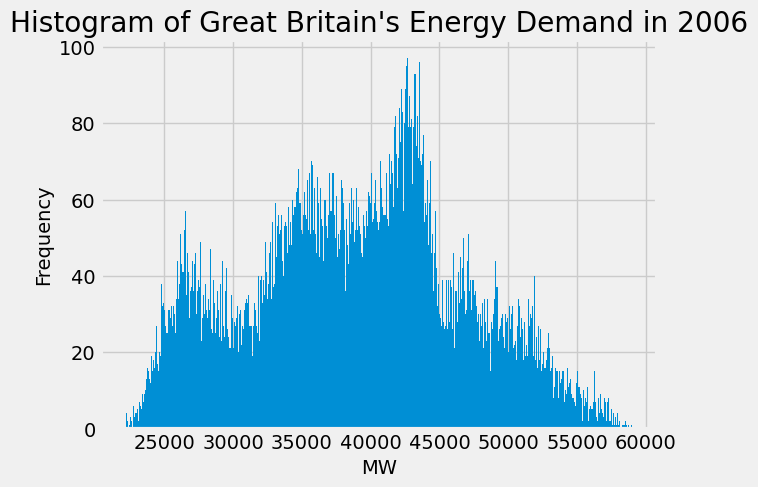

In [21]:
df.loc['2006', 'ND'].plot(kind='hist', bins=500, title="Histogram of Great Britain's Energy Demand in 2006")
plt.xlabel('MW')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

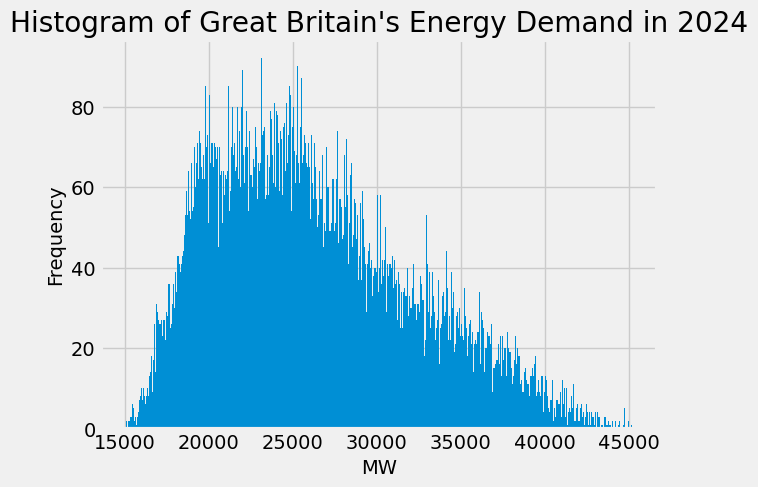

In [22]:
df.loc['2024', 'ND'].plot(kind='hist', bins=500, title="Histogram of Great Britain's Energy Demand in 2024")
plt.xlabel('MW')
plt.ylabel('Frequency')

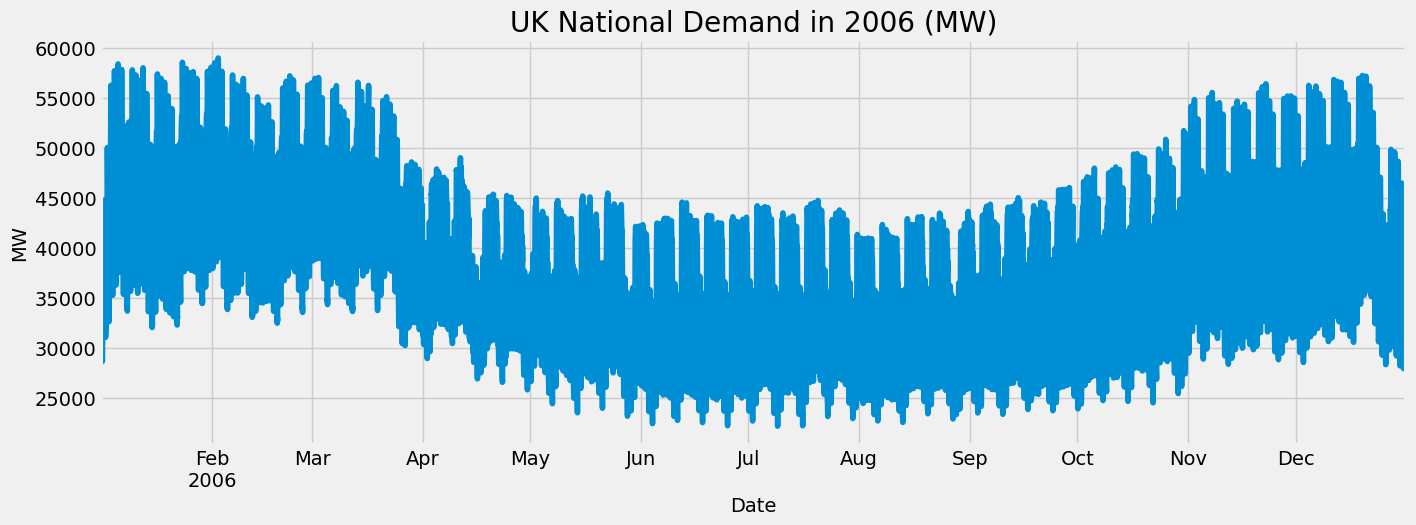

In [23]:
df.loc[(df.index > '2006-01-01') & (df.index < '2007-01-01')]['ND'] \
    .plot(figsize=(15, 5), title='UK National Demand in 2006 (MW)', xlabel = 'Date', ylabel = 'MW')
plt.show()

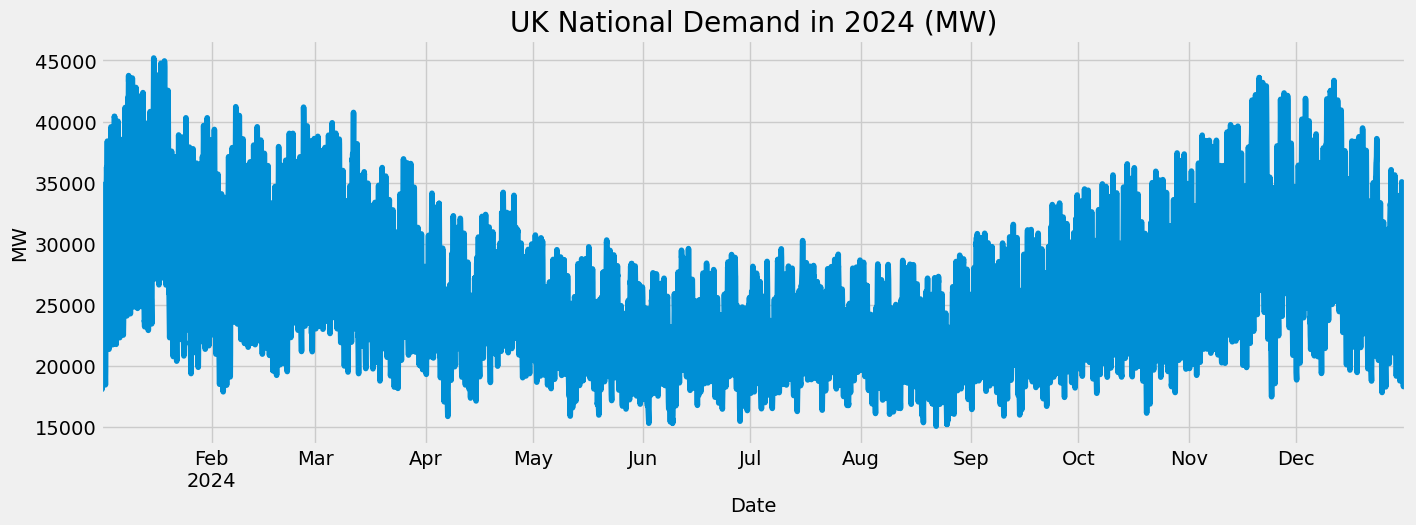

In [24]:
df.loc[(df.index > '2024-01-01') & (df.index < '2025-01-01')]['ND'] \
    .plot(figsize=(15, 5), title='UK National Demand in 2024 (MW)', xlabel = 'Date', ylabel = 'MW')
plt.show()

<Axes: title={'center': 'Potential Bottom End Outliers'}, xlabel='SETTLEMENT_DATETIME_UTC'>

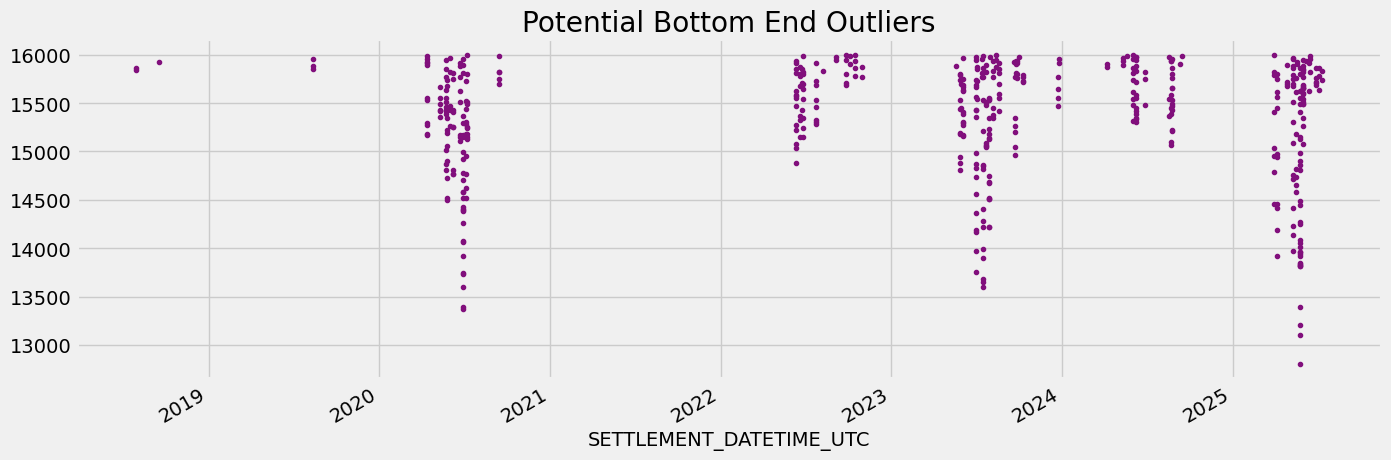

In [25]:
df.query('ND < 16000')['ND'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Potential Bottom End Outliers')

<Axes: title={'center': 'Potential Top End Outliers'}, xlabel='SETTLEMENT_DATETIME_UTC'>

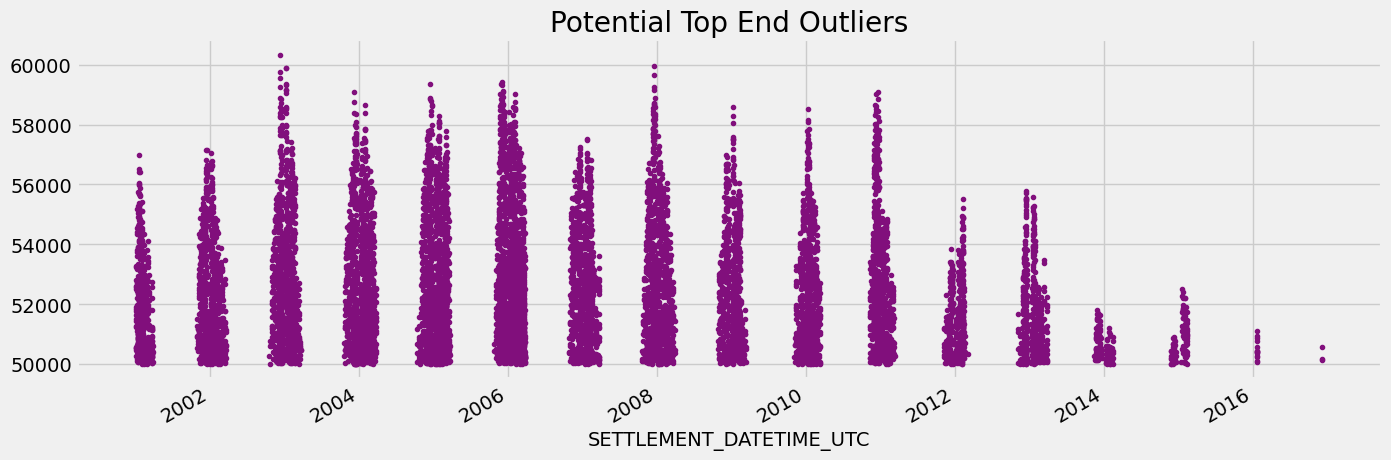

In [26]:
df.query('ND > 50000')['ND'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Potential Top End Outliers')

Although we do have some exceptionally low points of energy demand such as in 2025 when it drops below 13,000MW once, and in 2003 when it creeps above 60,000MW once, these look like genuine data points following the trends of the times of year. As such, and also because of the reliability and frequently updated nature of the NESO data, although it is good to be aware of these points we will not take any action to remove them as outliers at this time.

[Back to Contents](#Contents)

# 4. Feature Engineering

<Axes: xlabel='SETTLEMENT_DATETIME_UTC'>

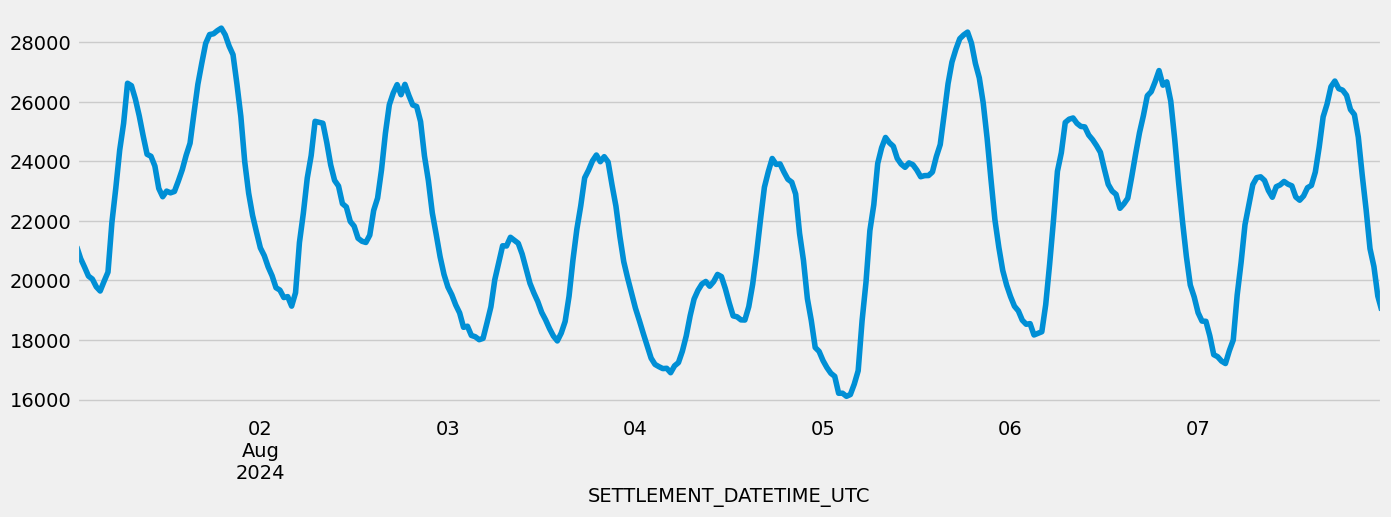

In [27]:
df.loc[(df.index > '2024-08-01') & (df.index < '2024-08-08')]['ND'].plot(figsize=(15, 5))

In [28]:
def create_calendar_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour']        = df.index.hour
    df['minute']      = df.index.minute
    df['day_of_week']   = df.index.dayofweek           # Mon=0 ... Sun=6
    df['is_weekend']  = df['day_of_week'] >= 5
    df['quarter']     = df.index.quarter
    df['month']       = df.index.month
    df['year']        = df.index.year
    df['day_of_year']   = df.index.dayofyear
    df['day_of_month']  = df.index.day
    df['week_of_year']  = df.index.isocalendar().week.astype(int)
    df['settlement_period'] = (df['hour'] * 2 + (df['minute'] // 30)) + 1
    df['half_hour_label'] = df.index.strftime('%H:%M')
    
    # Cyclical encoding for settlement_period
    max_sp = df['settlement_period'].max()
    df['sp_sin'] = np.sin(2 * np.pi * df['settlement_period'] / max_sp)
    df['sp_cos'] = np.cos(2 * np.pi * df['settlement_period'] / max_sp)

    # Holiday flag
    uk_holidays = holidays.UnitedKingdom()
    
    df['holiday_name'] = (
    df.index.tz_convert(None)
      .normalize()
      .map(lambda d: uk_holidays.get(d))
    )
    
    df['is_holiday'] = df['holiday_name'].notna()

    return df

df = create_calendar_features(df)

In [29]:
df.head()

ND SETTLEMENT_DATETIME_LOCAL  IS_DST  hour  \
SETTLEMENT_DATETIME_UTC                                                    
2001-01-01 00:00:00+00:00  38631 2001-01-01 00:00:00+00:00       0     0   
2001-01-01 00:30:00+00:00  39808 2001-01-01 00:30:00+00:00       0     0   
2001-01-01 01:00:00+00:00  40039 2001-01-01 01:00:00+00:00       0     1   
2001-01-01 01:30:00+00:00  39339 2001-01-01 01:30:00+00:00       0     1   
2001-01-01 02:00:00+00:00  38295 2001-01-01 02:00:00+00:00       0     2   

                           minute  day_of_week  is_weekend  quarter  month  \
SETTLEMENT_DATETIME_UTC                                                      
2001-01-01 00:00:00+00:00       0            0       False        1      1   
2001-01-01 00:30:00+00:00      30            0       False        1      1   
2001-01-01 01:00:00+00:00       0            0       False        1      1   
2001-01-01 01:30:00+00:00      30            0       False        1      1   
2001-01-01 02:00:00+00:00       0            0       False        1      1   

                           year  day_of_year  day_of_month  week_of_year  \
SETTLEMENT_DATETIME_UTC                                                    
2001-01-01 00:00:00+00:00  2001            1             1             1   
2001-01-01 00:30:00+00:00  2001            1             1             1   
2001-01-01 01:00:00+00:00  2001            1             1             1   
2001-01-01 01:30:00+00:00  2001            1             1             1   
2001-01-01 02:00:00+00:00  2001            1             1             1   

                           settlement_period half_hour_label    sp_sin  \
SETTLEMENT_DATETIME_UTC                                                  
2001-01-01 00:00:00+00:00                  1           00:00  0.130526   
2001-01-01 00:30:00+00:00                  2           00:30  0.258819   
2001-01-01 01:00:00+00:00                  3           01:00  0.382683   
2001-01-01 01:30:00+00:00                  4           01:30  0.500000   
2001-01-01 02:00:00+00:00                  5           02:00  0.608761   

                             sp_cos    holiday_name  is_holiday  
SETTLEMENT_DATETIME_UTC                                          
2001-01-01 00:00:00+00:00  0.991445  New Year's Day        True  
2001-01-01 00:30:00+00:00  0.965926  New Year's Day        True  
2001-01-01 01:00:00+00:00  0.923880  New Year's Day        True  
2001-01-01 01:30:00+00:00  0.866025  New Year's Day        True  
2001-01-01 02:00:00+00:00  0.793353  New Year's Day        True

In [30]:
def add_calendar_lags(df, target_col='ND', years=(1, 2, 3, 4, 5), method='exact', tolerance='15min'):
    """
    Add y-years-ago lag features aligned on calendar date & wall-clock time.
    - Uses pd.DateOffset(years=y) so leap years are handled.
    - If `method='exact'`, only exact timestamp matches are used; others are NaN.
    - If `method='nearest'`, the nearest timestamp within `tolerance` is used.
    """
    df = df.copy()
    s = df[target_col]

    for y in years:
        lag_idx = df.index - pd.DateOffset(years=y)
        col = f'ND_exactly_{y}_years_ago'
        if method == 'exact':
            # exact label match; no fill if missing
            df[col] = s.reindex(lag_idx).to_numpy()
        elif method == 'nearest':
            # nearest match within a tolerance (useful around DST glitches)
            df[col] = s.reindex(lag_idx, method='nearest', tolerance=tolerance).to_numpy()
        else:
            raise ValueError("method must be 'exact' or 'nearest'")

    return df

# Example:
# df = add_calendar_lags(df, target_col='ND', years=(1,2,3), method='exact'

In [31]:
df = add_calendar_lags(df, target_col='ND', years=(1,2,3,4,5), method='exact')

In [32]:
df.head()

ND SETTLEMENT_DATETIME_LOCAL  IS_DST  hour  \
SETTLEMENT_DATETIME_UTC                                                    
2001-01-01 00:00:00+00:00  38631 2001-01-01 00:00:00+00:00       0     0   
2001-01-01 00:30:00+00:00  39808 2001-01-01 00:30:00+00:00       0     0   
2001-01-01 01:00:00+00:00  40039 2001-01-01 01:00:00+00:00       0     1   
2001-01-01 01:30:00+00:00  39339 2001-01-01 01:30:00+00:00       0     1   
2001-01-01 02:00:00+00:00  38295 2001-01-01 02:00:00+00:00       0     2   

                           minute  day_of_week  is_weekend  quarter  month  \
SETTLEMENT_DATETIME_UTC                                                      
2001-01-01 00:00:00+00:00       0            0       False        1      1   
2001-01-01 00:30:00+00:00      30            0       False        1      1   
2001-01-01 01:00:00+00:00       0            0       False        1      1   
2001-01-01 01:30:00+00:00      30            0       False        1      1   
2001-01-01 02:00:00+00:00       0            0       False        1      1   

                           year  ...  half_hour_label    sp_sin    sp_cos  \
SETTLEMENT_DATETIME_UTC          ...                                        
2001-01-01 00:00:00+00:00  2001  ...            00:00  0.130526  0.991445   
2001-01-01 00:30:00+00:00  2001  ...            00:30  0.258819  0.965926   
2001-01-01 01:00:00+00:00  2001  ...            01:00  0.382683  0.923880   
2001-01-01 01:30:00+00:00  2001  ...            01:30  0.500000  0.866025   
2001-01-01 02:00:00+00:00  2001  ...            02:00  0.608761  0.793353   

                             holiday_name is_holiday  ND_exactly_1_years_ago  \
SETTLEMENT_DATETIME_UTC                                                        
2001-01-01 00:00:00+00:00  New Year's Day       True                     NaN   
2001-01-01 00:30:00+00:00  New Year's Day       True                     NaN   
2001-01-01 01:00:00+00:00  New Year's Day       True                     NaN   
2001-01-01 01:30:00+00:00  New Year's Day       True                     NaN   
2001-01-01 02:00:00+00:00  New Year's Day       True                     NaN   

                           ND_exactly_2_years_ago ND_exactly_3_years_ago  \
SETTLEMENT_DATETIME_UTC                                                    
2001-01-01 00:00:00+00:00                     NaN                    NaN   
2001-01-01 00:30:00+00:00                     NaN                    NaN   
2001-01-01 01:00:00+00:00                     NaN                    NaN   
2001-01-01 01:30:00+00:00                     NaN                    NaN   
2001-01-01 02:00:00+00:00                     NaN                    NaN   

                           ND_exactly_4_years_ago  ND_exactly_5_years_ago  
SETTLEMENT_DATETIME_UTC                                                    
2001-01-01 00:00:00+00:00                     NaN                     NaN  
2001-01-01 00:30:00+00:00                     NaN                     NaN  
2001-01-01 01:00:00+00:00                     NaN                     NaN  
2001-01-01 01:30:00+00:00                     NaN                     NaN  
2001-01-01 02:00:00+00:00                     NaN                     NaN  

[5 rows x 24 columns]

In [33]:
df.tail()

ND SETTLEMENT_DATETIME_LOCAL  IS_DST  hour  \
SETTLEMENT_DATETIME_UTC                                                    
2025-07-22 20:30:00+00:00  26499 2025-07-22 21:30:00+01:00       1    20   
2025-07-22 21:00:00+00:00  25492 2025-07-22 22:00:00+01:00       1    21   
2025-07-22 21:30:00+00:00  24543 2025-07-22 22:30:00+01:00       1    21   
2025-07-22 22:00:00+00:00  23637 2025-07-22 23:00:00+01:00       1    22   
2025-07-22 22:30:00+00:00  22323 2025-07-22 23:30:00+01:00       1    22   

                           minute  day_of_week  is_weekend  quarter  month  \
SETTLEMENT_DATETIME_UTC                                                      
2025-07-22 20:30:00+00:00      30            1       False        3      7   
2025-07-22 21:00:00+00:00       0            1       False        3      7   
2025-07-22 21:30:00+00:00      30            1       False        3      7   
2025-07-22 22:00:00+00:00       0            1       False        3      7   
2025-07-22 22:30:00+00:00      30            1       False        3      7   

                           year  ...  half_hour_label    sp_sin    sp_cos  \
SETTLEMENT_DATETIME_UTC          ...                                        
2025-07-22 20:30:00+00:00  2025  ...            20:30 -0.707107  0.707107   
2025-07-22 21:00:00+00:00  2025  ...            21:00 -0.608761  0.793353   
2025-07-22 21:30:00+00:00  2025  ...            21:30 -0.500000  0.866025   
2025-07-22 22:00:00+00:00  2025  ...            22:00 -0.382683  0.923880   
2025-07-22 22:30:00+00:00  2025  ...            22:30 -0.258819  0.965926   

                           holiday_name is_holiday  ND_exactly_1_years_ago  \
SETTLEMENT_DATETIME_UTC                                                      
2025-07-22 20:30:00+00:00          None      False                 26183.0   
2025-07-22 21:00:00+00:00          None      False                 25126.0   
2025-07-22 21:30:00+00:00          None      False                 24074.0   
2025-07-22 22:00:00+00:00          None      False                 22979.0   
2025-07-22 22:30:00+00:00          None      False                 22025.0   

                           ND_exactly_2_years_ago ND_exactly_3_years_ago  \
SETTLEMENT_DATETIME_UTC                                                    
2025-07-22 20:30:00+00:00                 22617.0                25698.0   
2025-07-22 21:00:00+00:00                 22061.0                25162.0   
2025-07-22 21:30:00+00:00                 21031.0                24267.0   
2025-07-22 22:00:00+00:00                 19793.0                22701.0   
2025-07-22 22:30:00+00:00                 18805.0                21713.0   

                           ND_exactly_4_years_ago  ND_exactly_5_years_ago  
SETTLEMENT_DATETIME_UTC                                                    
2025-07-22 20:30:00+00:00                 29685.0                 27142.0  
2025-07-22 21:00:00+00:00                 28843.0                 26252.0  
2025-07-22 21:30:00+00:00                 27720.0                 24987.0  
2025-07-22 22:00:00+00:00                 26039.0                 23480.0  
2025-07-22 22:30:00+00:00                 24609.0                 22184.0  

[5 rows x 24 columns]

In [34]:
df.loc[(df.index > '2024-08-01') & (df.index < '2024-08-08')]

ND SETTLEMENT_DATETIME_LOCAL  IS_DST  hour  \
SETTLEMENT_DATETIME_UTC                                                    
2024-08-01 00:30:00+00:00  21139 2024-08-01 01:30:00+01:00       1     0   
2024-08-01 01:00:00+00:00  20735 2024-08-01 02:00:00+01:00       1     1   
2024-08-01 01:30:00+00:00  20450 2024-08-01 02:30:00+01:00       1     1   
2024-08-01 02:00:00+00:00  20148 2024-08-01 03:00:00+01:00       1     2   
2024-08-01 02:30:00+00:00  20048 2024-08-01 03:30:00+01:00       1     2   
...                          ...                       ...     ...   ...   
2024-08-07 21:30:00+00:00  22384 2024-08-07 22:30:00+01:00       1    21   
2024-08-07 22:00:00+00:00  21068 2024-08-07 23:00:00+01:00       1    22   
2024-08-07 22:30:00+00:00  20468 2024-08-07 23:30:00+01:00       1    22   
2024-08-07 23:00:00+00:00  19476 2024-08-08 00:00:00+01:00       1    23   
2024-08-07 23:30:00+00:00  18994 2024-08-08 00:30:00+01:00       1    23   

                           minute  day_of_week  is_weekend  quarter  month  \
SETTLEMENT_DATETIME_UTC                                                      
2024-08-01 00:30:00+00:00      30            3       False        3      8   
2024-08-01 01:00:00+00:00       0            3       False        3      8   
2024-08-01 01:30:00+00:00      30            3       False        3      8   
2024-08-01 02:00:00+00:00       0            3       False        3      8   
2024-08-01 02:30:00+00:00      30            3       False        3      8   
...                           ...          ...         ...      ...    ...   
2024-08-07 21:30:00+00:00      30            2       False        3      8   
2024-08-07 22:00:00+00:00       0            2       False        3      8   
2024-08-07 22:30:00+00:00      30            2       False        3      8   
2024-08-07 23:00:00+00:00       0            2       False        3      8   
2024-08-07 23:30:00+00:00      30            2       False        3      8   

                           year  ...  half_hour_label        sp_sin    sp_cos  \
SETTLEMENT_DATETIME_UTC          ...                                            
2024-08-01 00:30:00+00:00  2024  ...            00:30  2.588190e-01  0.965926   
2024-08-01 01:00:00+00:00  2024  ...            01:00  3.826834e-01  0.923880   
2024-08-01 01:30:00+00:00  2024  ...            01:30  5.000000e-01  0.866025   
2024-08-01 02:00:00+00:00  2024  ...            02:00  6.087614e-01  0.793353   
2024-08-01 02:30:00+00:00  2024  ...            02:30  7.071068e-01  0.707107   
...                         ...  ...              ...           ...       ...   
2024-08-07 21:30:00+00:00  2024  ...            21:30 -5.000000e-01  0.866025   
2024-08-07 22:00:00+00:00  2024  ...            22:00 -3.826834e-01  0.923880   
2024-08-07 22:30:00+00:00  2024  ...            22:30 -2.588190e-01  0.965926   
2024-08-07 23:00:00+00:00  2024  ...            23:00 -1.305262e-01  0.991445   
2024-08-07 23:30:00+00:00  2024  ...            23:30 -2.449294e-16  1.000000   

                           holiday_name is_holiday  ND_exactly_1_years_ago  \
SETTLEMENT_DATETIME_UTC                                                      
2024-08-01 00:30:00+00:00          None      False                 17591.0   
2024-08-01 01:00:00+00:00          None      False                 17310.0   
2024-08-01 01:30:00+00:00          None      False                 16812.0   
2024-08-01 02:00:00+00:00          None      False                 16744.0   
2024-08-01 02:30:00+00:00          None      False                 16608.0   
...                                 ...        ...                     ...   
2024-08-07 21:30:00+00:00          None      False                 22486.0   
2024-08-07 22:00:00+00:00          None      False                 21232.0   
2024-08-07 22:30:00+00:00          None      False                 19936.0   
2024-08-07 23:00:00+00:00          None      False                 19281.0   
2024-08-07 23:30:00+00:00          N

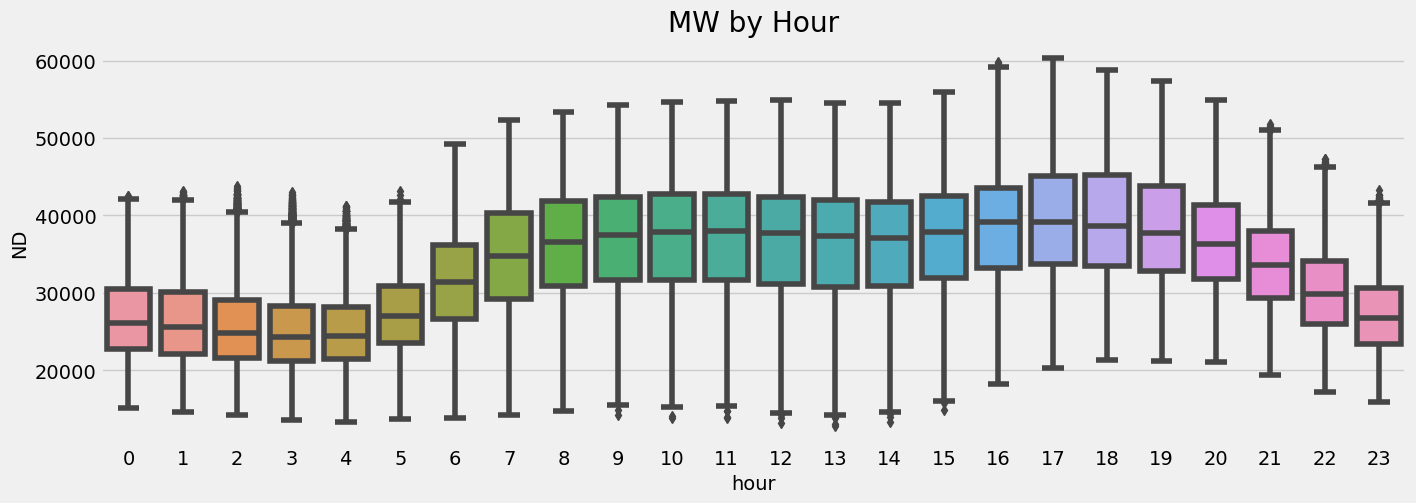

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='hour', y='ND')
ax.set_title('MW by Hour')
plt.show()

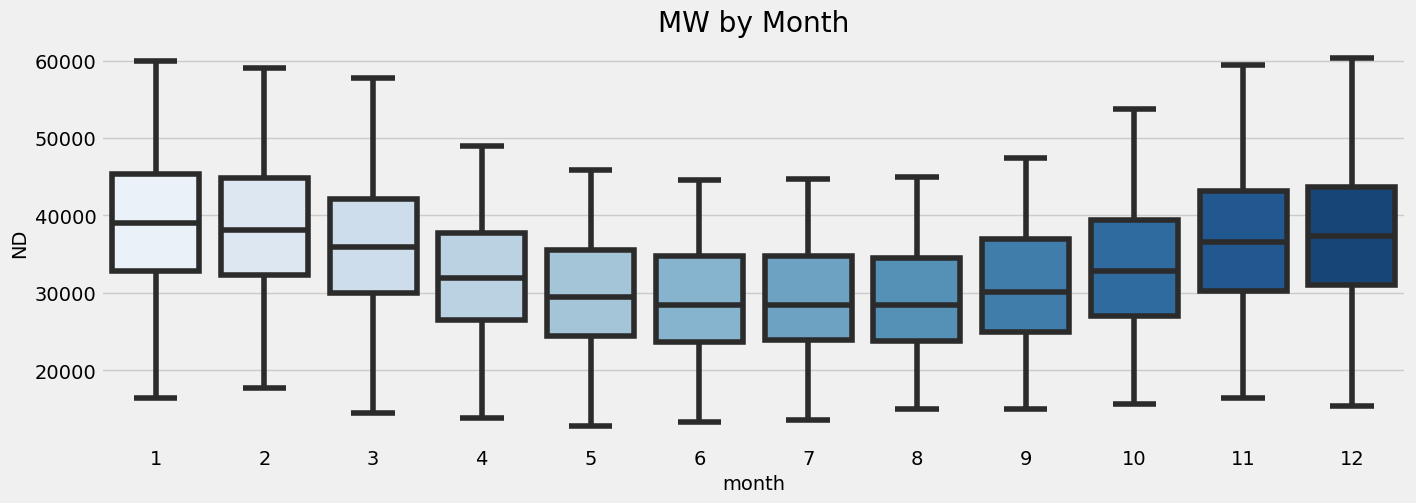

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='month', y='ND', palette = 'Blues')
ax.set_title('MW by Month')
plt.show()

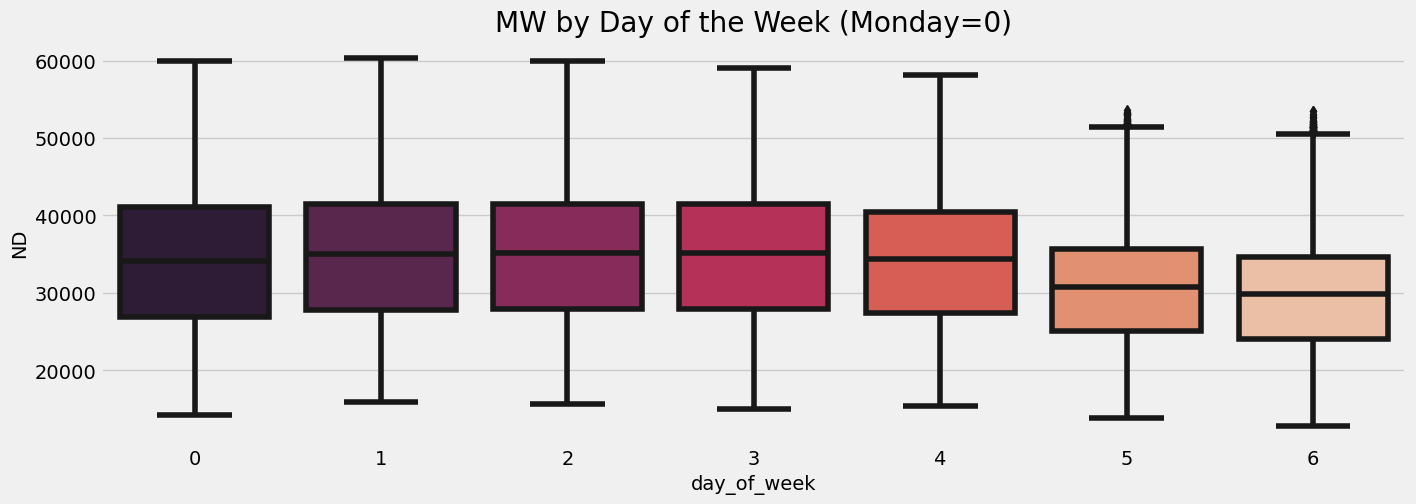

In [37]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='day_of_week', y='ND', palette = 'rocket')
ax.set_title('MW by Day of the Week (Monday=0)')
plt.show()

# 5. Training the Model

[0]	validation_0-rmse:35710.93983	validation_1-rmse:28672.25622
[100]	validation_0-rmse:13488.08611	validation_1-rmse:10663.40069
[200]	validation_0-rmse:5644.15717	validation_1-rmse:4860.24144
[300]	validation_0-rmse:3165.31913	validation_1-rmse:3690.62277
[400]	validation_0-rmse:2500.46428	validation_1-rmse:3333.31451
[500]	validation_0-rmse:2308.46052	validation_1-rmse:3303.52981
[531]	validation_0-rmse:2275.93827	validation_1-rmse:3300.72783
Fold 1: RMSE=3294.01, MAPE=9.40%


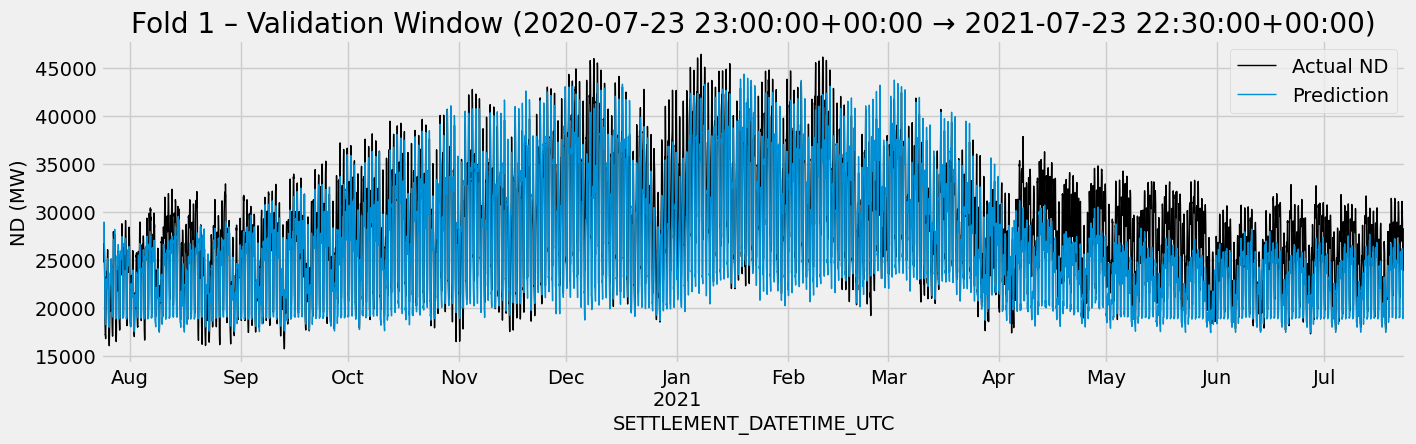

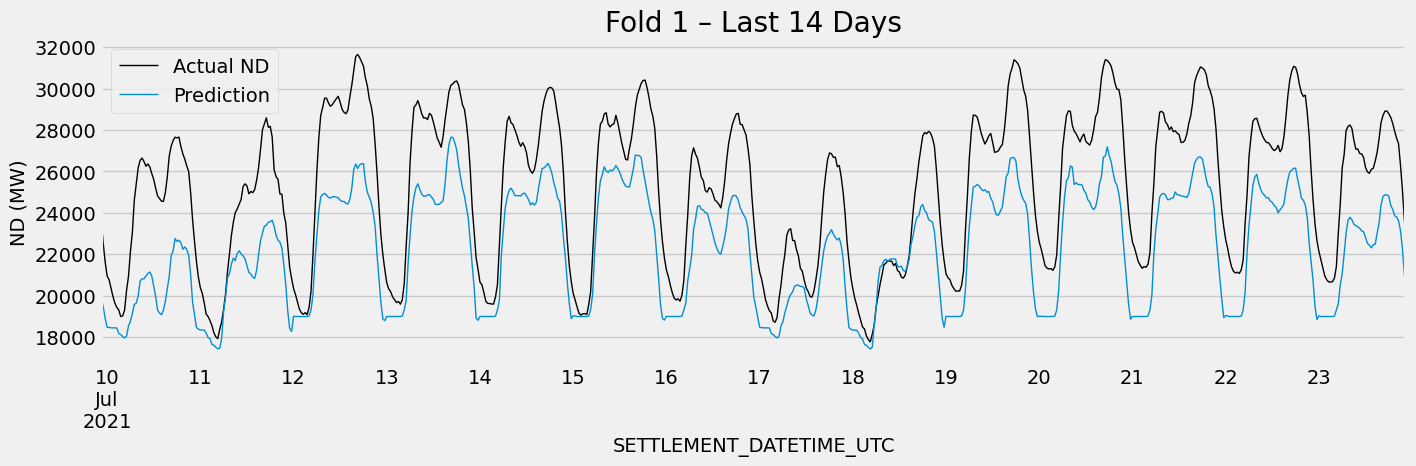

[0]	validation_0-rmse:35401.21239	validation_1-rmse:27894.18564
[100]	validation_0-rmse:13375.05411	validation_1-rmse:10042.09130
[200]	validation_0-rmse:5609.17569	validation_1-rmse:4084.60125
[300]	validation_0-rmse:3176.37685	validation_1-rmse:2524.29591
[400]	validation_0-rmse:2535.37982	validation_1-rmse:2216.03443
[500]	validation_0-rmse:2355.71979	validation_1-rmse:2156.26817
[572]	validation_0-rmse:2285.58878	validation_1-rmse:2157.20204
Fold 2: RMSE=2150.99, MAPE=6.27%


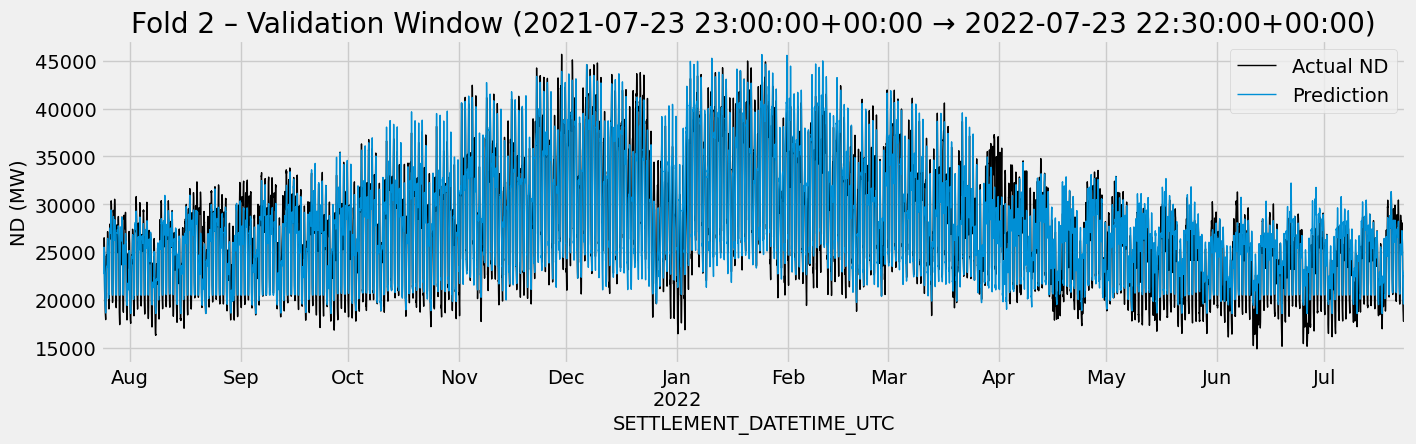

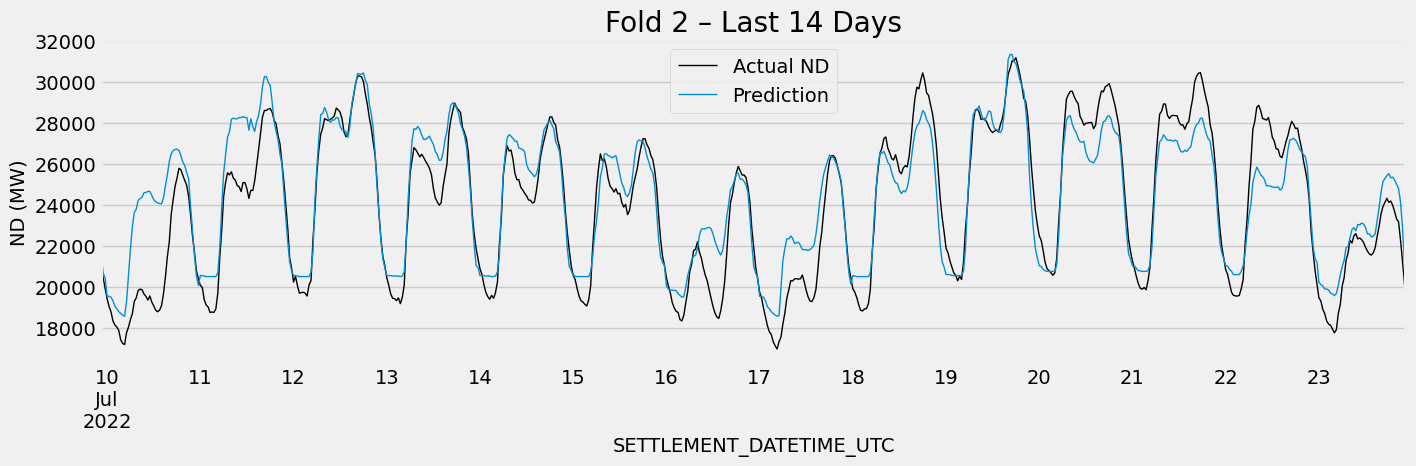

[0]	validation_0-rmse:35089.31594	validation_1-rmse:26499.06691
[100]	validation_0-rmse:13259.99544	validation_1-rmse:8967.77660
[200]	validation_0-rmse:5563.52932	validation_1-rmse:3316.05695
[300]	validation_0-rmse:3157.30128	validation_1-rmse:2297.63914
[375]	validation_0-rmse:2613.63212	validation_1-rmse:2306.84703
Fold 3: RMSE=2282.59, MAPE=7.08%


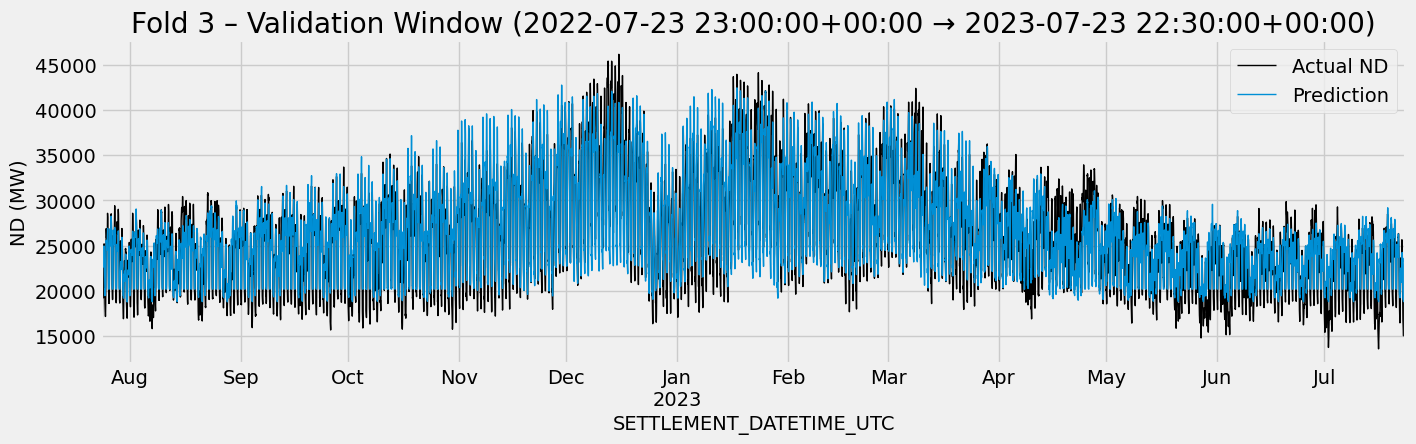

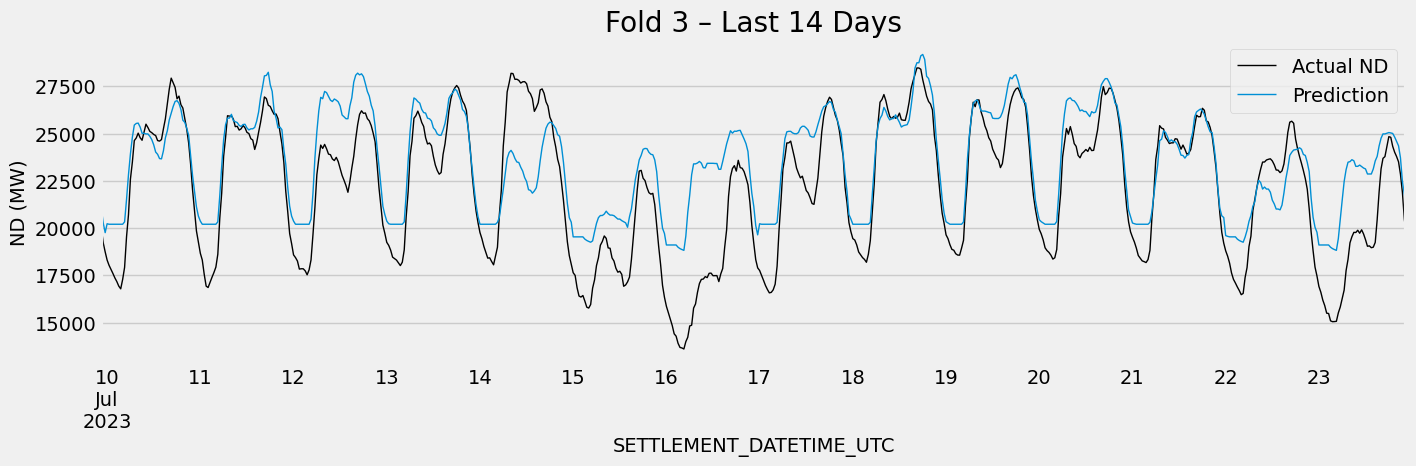

[0]	validation_0-rmse:34754.45227	validation_1-rmse:26495.84781
[100]	validation_0-rmse:13140.60015	validation_1-rmse:9689.43642
[200]	validation_0-rmse:5522.21402	validation_1-rmse:4113.18507
[300]	validation_0-rmse:3150.95767	validation_1-rmse:2673.23544
[400]	validation_0-rmse:2529.36658	validation_1-rmse:2381.63463
[500]	validation_0-rmse:2351.84869	validation_1-rmse:2307.86467
[600]	validation_0-rmse:2267.43440	validation_1-rmse:2276.89556
[700]	validation_0-rmse:2207.89825	validation_1-rmse:2266.56980
[800]	validation_0-rmse:2159.23803	validation_1-rmse:2263.01638
[900]	validation_0-rmse:2118.08599	validation_1-rmse:2261.21640
[950]	validation_0-rmse:2100.63682	validation_1-rmse:2264.51956
Fold 4: RMSE=2260.64, MAPE=6.71%


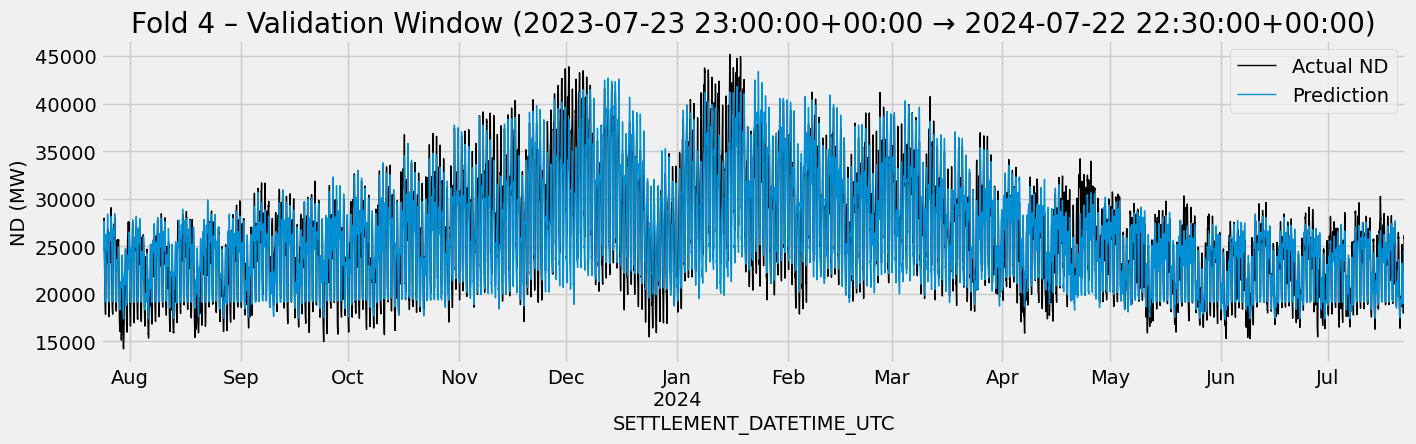

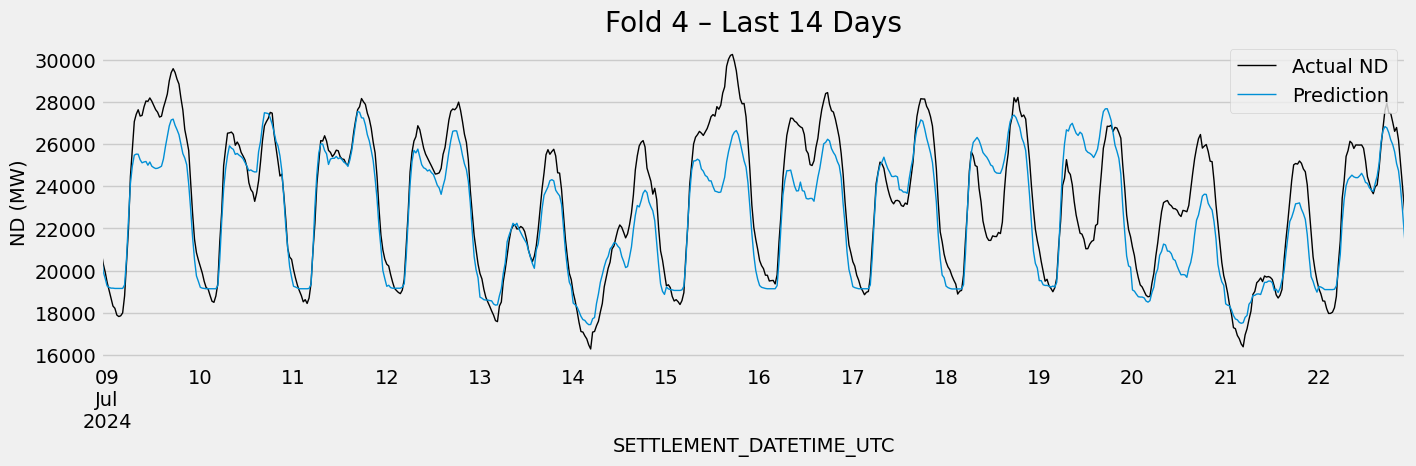

[0]	validation_0-rmse:34444.29504	validation_1-rmse:26725.15239
[100]	validation_0-rmse:13025.81180	validation_1-rmse:10401.24745
[200]	validation_0-rmse:5481.78446	validation_1-rmse:4904.75429
[300]	validation_0-rmse:3140.44034	validation_1-rmse:3328.31115
[400]	validation_0-rmse:2526.56637	validation_1-rmse:2861.94403
[500]	validation_0-rmse:2354.61324	validation_1-rmse:2727.58464
[600]	validation_0-rmse:2270.31742	validation_1-rmse:2696.73576
[700]	validation_0-rmse:2212.89822	validation_1-rmse:2680.49788
[800]	validation_0-rmse:2163.34981	validation_1-rmse:2672.01776
[900]	validation_0-rmse:2125.20437	validation_1-rmse:2666.48177
[999]	validation_0-rmse:2093.31722	validation_1-rmse:2660.13415
Fold 5: RMSE=2660.11, MAPE=7.76%


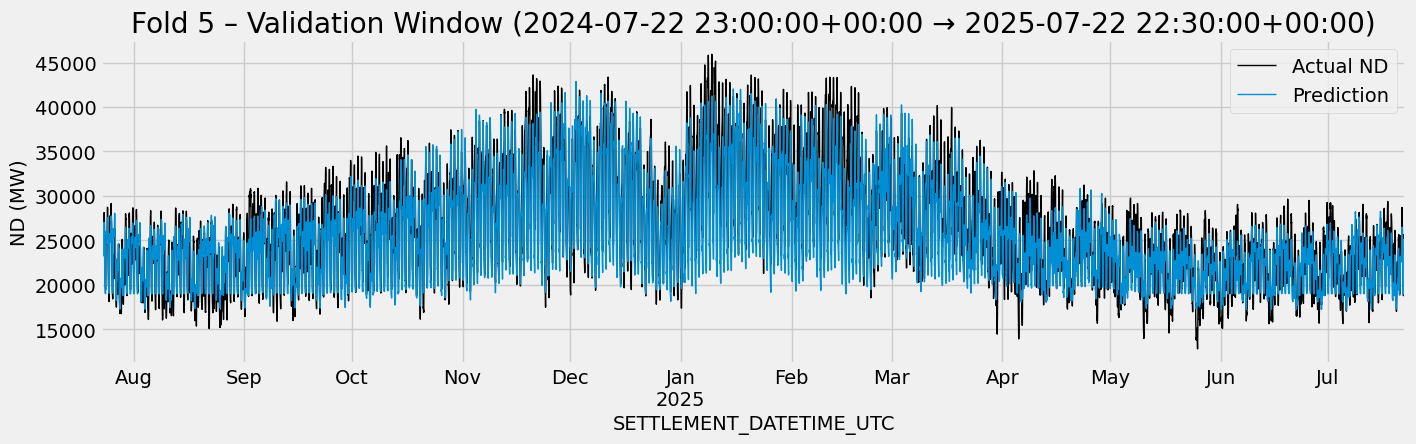

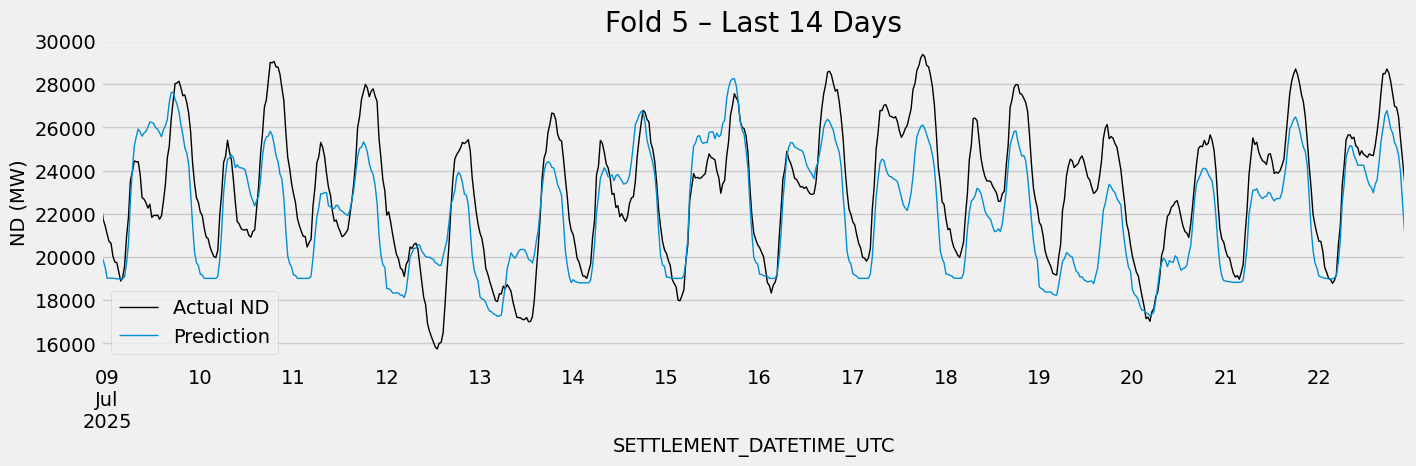

In [38]:
YEAR = 17520    # 17,532 can be used for full year as 17520 is not accounting for leap years but as neither 2025 
                # or 2026 are leap years this will keep the years we are looking at specifically aligned
GAP  = 48       # 48*30 when using rolling averages up to a month (30 days)

tss = TimeSeriesSplit(n_splits=5, test_size=YEAR, gap=GAP)

df = df.sort_index()

# container for OOF predictions (same index as df)
oof_pred = pd.Series(index=df.index, dtype=float, name='prediction')
fold_rmses = []
fold_mapes = []
scores = []
feature_importance_list = []

fold = 1
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx].copy()
    test  = df.iloc[val_idx].copy()
    
    

    # features
    train = create_calendar_features(train)
    test  = create_calendar_features(test)

    FEATURES = [
        'day_of_week','is_weekend','quarter','month','year',
        'day_of_year','day_of_month','week_of_year','settlement_period',
        'ND_exactly_1_years_ago','ND_exactly_2_years_ago','ND_exactly_3_years_ago',
        'ND_exactly_4_years_ago','ND_exactly_5_years_ago',
        'sp_sin', 'sp_cos', 'is_holiday', 'IS_DST'
    ]
    TARGET = 'ND'
    
    cols = FEATURES + [TARGET]
    train_ = train[cols].dropna()
    test_  = test[cols].dropna()

    X_train, y_train = train[FEATURES], train[TARGET]
    X_test,  y_test  = test[FEATURES],  test[TARGET]

    reg = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=3,
        objective='reg:squarederror',
        booster='gbtree',
        base_score=0.5,
        early_stopping_rounds=50
    )
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

    y_pred = reg.predict(X_test)
    oof_pred.loc[X_test.index] = y_pred

    # fold metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(rmse)
    mape = ((np.abs(y_pred - y_test) / y_test).replace([np.inf, -np.inf], np.nan).dropna()).mean() * 100
    fold_rmses.append(rmse)
    fold_mapes.append(mape)

    print(f"Fold {fold}: RMSE={rmse:.2f}, MAPE={mape:.2f}%")

    # Store feature importance
    fold_importance = pd.DataFrame({
        'feature': FEATURES,
        'importance': reg.feature_importances_,
        'fold': fold
    })
    feature_importance_list.append(fold_importance)
    
    # hash if plotting folds
    #fold += 1

    # ---------- PLOTS FOR THIS FOLD ----------
    val_plot = pd.DataFrame({'ND': y_test, 'pred': y_pred}, index=X_test.index)

    # 1) Full validation window
    fig, ax = plt.subplots(figsize=(15, 4))
    val_plot['ND'].plot(ax=ax, lw=1, label='Actual ND', color='black')
    val_plot['pred'].plot(ax=ax, lw=1, label='Prediction')
    ax.set_title(f'Fold {fold} – Validation Window ({val_plot.index.min()} → {val_plot.index.max()})')
    ax.set_ylabel('ND (MW)')
    ax.legend()
    plt.show()

    # 2) Zoom: last 14 days of the fold
    zoom_start = val_plot.index.max() - pd.Timedelta(days=14)
    val_zoom = val_plot.loc[zoom_start:]
    fig, ax = plt.subplots(figsize=(15, 4))
    val_zoom['ND'].plot(ax=ax, lw=1, label='Actual ND', color='black')
    val_zoom['pred'].plot(ax=ax, lw=1, label='Prediction')
    ax.set_title(f'Fold {fold} – Last 14 Days')
    ax.set_ylabel('ND (MW)')
    ax.legend()
    plt.show()

    # unhash if plotting folds
    fold += 1

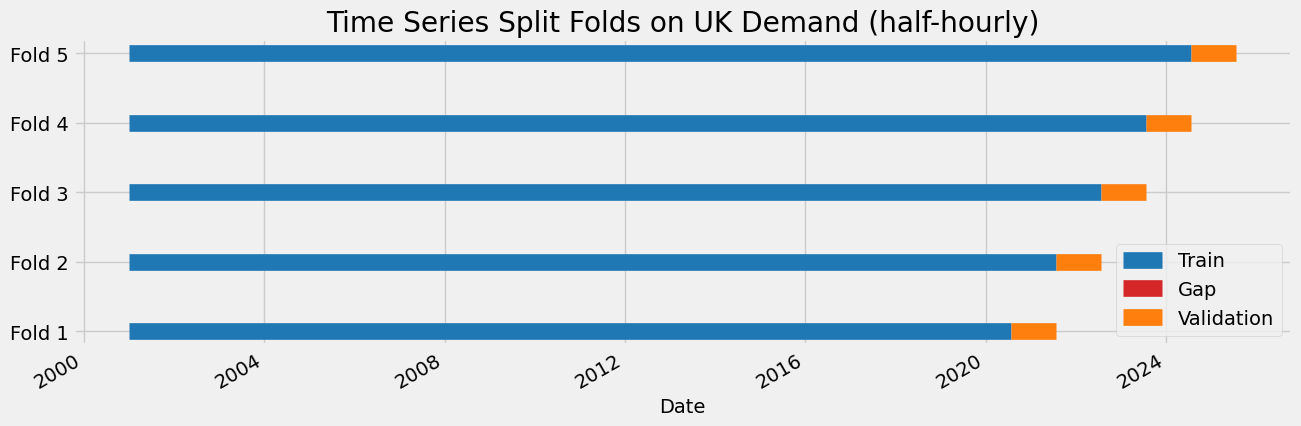

In [39]:
# Extract parameters from your existing TSS object
n_splits = tss.n_splits
test_size = tss.test_size
gap = tss.gap

idx = df.index

title = "Time Series Split Folds on UK Demand (half-hourly)"
fig, ax = plt.subplots(figsize=(14, 0.5*n_splits + 2))
for fold, (train_idx, test_idx) in enumerate(tss.split(df), start=1):
    y = fold

    # Train span
    ax.hlines(y, idx[train_idx[0]], idx[train_idx[-1]],
              colors='tab:blue', linewidth=12, label='Train' if fold == 1 else None)

    # Gap span (if any)
    # There is a gap if the first test index is beyond the last train index + 1
    if test_idx[0] - train_idx[-1] > 1:
        gap_start = idx[train_idx[-1] + 1]
        gap_end   = idx[test_idx[0] - 1]
        ax.hlines(y, gap_start, gap_end,
                  colors='tab:red', linewidth=12, label='Gap' if fold == 1 else None)

    # Validation/Test span
    ax.hlines(y, idx[test_idx[0]], idx[test_idx[-1]],
              colors='tab:orange', linewidth=12, label='Validation' if fold == 1 else None)

ax.set_yticks(range(1, n_splits + 1))
ax.set_yticklabels([f'Fold {i}' for i in range(1, n_splits + 1)])
ax.set_xlabel('Date')
ax.set_title(title or f"TimeSeriesSplit (test_size={test_size}, gap={gap})")
ax.legend(loc='lower right')
fig.autofmt_xdate()
plt.show()

[Back to Contents](#Contents)

# 6. Evaluating the Model

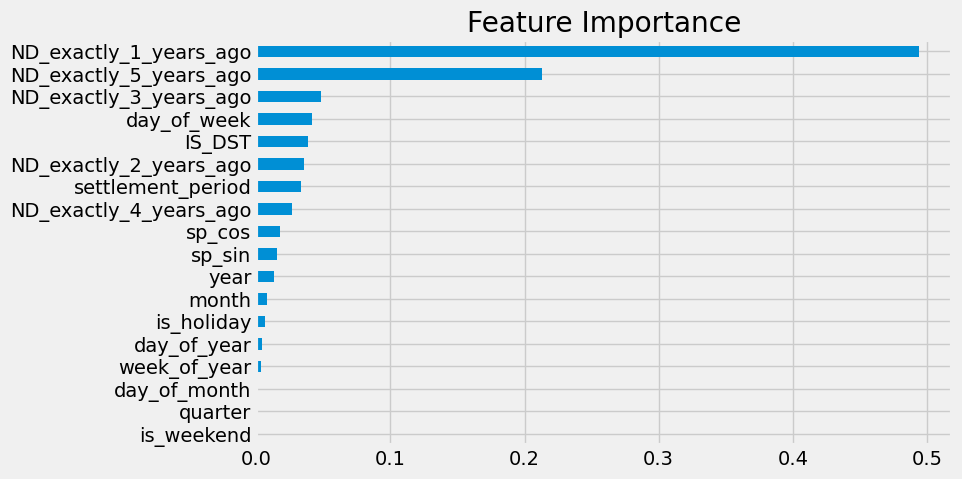

                        importance
is_weekend                0.000000
quarter                   0.000000
day_of_month              0.000839
week_of_year              0.003513
day_of_year               0.004147
is_holiday                0.006554
month                     0.007908
year                      0.012859
sp_sin                    0.015235
sp_cos                    0.017320
ND_exactly_4_years_ago    0.026676
settlement_period         0.033483
ND_exactly_2_years_ago    0.035346
IS_DST                    0.038768
day_of_week               0.041700
ND_exactly_3_years_ago    0.048066
ND_exactly_5_years_ago    0.213311
ND_exactly_1_years_ago    0.494275
importance    1.0
dtype: float32


In [40]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi_sorted = fi.sort_values('importance')

fi_sorted.plot(kind='barh', title='Feature Importance', legend=False, figsize=(8,5))
plt.show()

# Print sorted DataFrame
print(fi_sorted)
print(fi_sorted.sum())

In [41]:
pred_df = pd.DataFrame({'ND': df['ND'], 'prediction': oof_pred})

# keep rows that have both truth and prediction
valid = pred_df['ND'].notna() & pred_df['prediction'].notna()
y_true = pred_df.loc[valid, 'ND']
y_pred = pred_df.loc[valid, 'prediction']

# core errors
err   = y_pred - y_true
mae   = np.mean(np.abs(err))
rmse  = np.sqrt(np.mean(err**2))
nrmse = rmse / y_true.mean()

# % errors — guard against divide-by-zero
eps = 1e-6
nonzero = y_true.abs() > eps
mape  = (np.abs(err[nonzero]) / y_true[nonzero]).mean() * 100

den = (y_true.abs() + y_pred.abs())
valid_den = den > eps
smape = (200 * (np.abs(err[valid_den]) / den[valid_den])).mean()

print(f"Used {valid.sum():,} OOF points for metrics (out of {len(pred_df):,}).")
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | nRMSE: {nrmse:.4f}")
print(f"MAPE: {mape:.2f}% | SMAPE: {smape:.2f}%")

print(f"Fold RMSEs: {[round(s,2) for s in scores]} | Mean RMSE: {np.mean(scores):.2f}")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, nRMSE: {nrmse:.4f}, SMAPE: {smape:.2f}%")

Used 87,600 OOF points for metrics (out of 430,510).
MAE: 1983.45 | RMSE: 2564.14 | nRMSE: 0.0955
MAPE: 7.44% | SMAPE: 7.53%
Fold RMSEs: [3294.01, 2150.99, 2282.59, 2260.64, 2660.11] | Mean RMSE: 2529.67
MAE: 1983.45, RMSE: 2564.14, nRMSE: 0.0955, SMAPE: 7.53%


In [42]:
err = y_pred - y_true

# Weighted MAPE (stable when values vary a lot)
wmape = (np.abs(err).sum() / np.abs(y_true).sum()) * 100

# Normalised RMSE by mean ND
nrmse_overall = np.sqrt(np.mean(err**2)) / y_true.mean()

print(f"wMAPE: {wmape:.2f}% | nRMSE: {nrmse_overall:.4f}")

# nRMSE by month
nrmse_by_month = (
    pd.DataFrame({'y_true': y_true, 'err': err})
    .groupby(y_true.index.month)
    .apply(lambda g: np.sqrt(np.mean(g['err']**2)) / g['y_true'].mean())
)
print("\nNormalised RMSE by Month:")
print(nrmse_by_month)

# nRMSE by settlement period
nrmse_by_sp = (
    pd.DataFrame({'y_true': y_true, 'err': err})
    .groupby(y_true.index.hour * 2 + (y_true.index.minute // 30) + 1)
    .apply(lambda g: np.sqrt(np.mean(g['err']**2)) / g['y_true'].mean())
)
print("\nNormalised RMSE by Settlement Period:")
print(nrmse_by_sp)

wMAPE: 7.39% | nRMSE: 0.0955

Normalised RMSE by Month:
SETTLEMENT_DATETIME_UTC
1     0.100078
2     0.097388
3     0.085525
4     0.117459
5     0.120897
6     0.099224
7     0.095312
8     0.078723
9     0.075620
10    0.080865
11    0.081475
12    0.096845
dtype: float64

Normalised RMSE by Settlement Period:
SETTLEMENT_DATETIME_UTC
1     0.089177
2     0.090952
3     0.091917
4     0.093227
5     0.095379
6     0.096319
7     0.097568
8     0.097925
9     0.094605
10    0.092255
11    0.091871
12    0.092172
13    0.094490
14    0.097152
15    0.098361
16    0.097755
17    0.096325
18    0.096191
19    0.097555
20    0.099969
21    0.102878
22    0.105976
23    0.108856
24    0.111519
25    0.113805
26    0.115344
27    0.115546
28    0.114532
29    0.112448
30    0.109274
31    0.103438
32    0.095882
33    0.088528
34    0.082604
35    0.077954
36    0.075333
37    0.073799
38    0.075495
39    0.076944
40    0.079373
41    0.080960
42    0.083787
43    0.086157
44    0.089450
45

In [43]:
print("Any NaNs left in OOF preds?", oof_pred.isna().any())
missing_in_oof = df.index.difference(oof_pred.dropna().index)
print("Rows without OOF preds (earliest train-only etc.):", len(missing_in_oof))

Any NaNs left in OOF preds? True
Rows without OOF preds (earliest train-only etc.): 342910


In [44]:
df = df.join(oof_pred)   # guarantees a 'prediction' column

In [45]:
# Make DataFrame with OOF predictions and actuals
errors_df = df.copy()
errors_df['prediction'] = oof_pred
errors_df = errors_df.dropna(subset=['prediction'])  # only rows that have predictions

# Error columns
errors_df['error'] = errors_df['prediction'] - errors_df['ND']
errors_df['abs_error'] = errors_df['error'].abs()
errors_df['pct_error'] = errors_df['error'] / errors_df['ND'] * 100
errors_df['abs_pct_error'] = errors_df['pct_error'].abs()

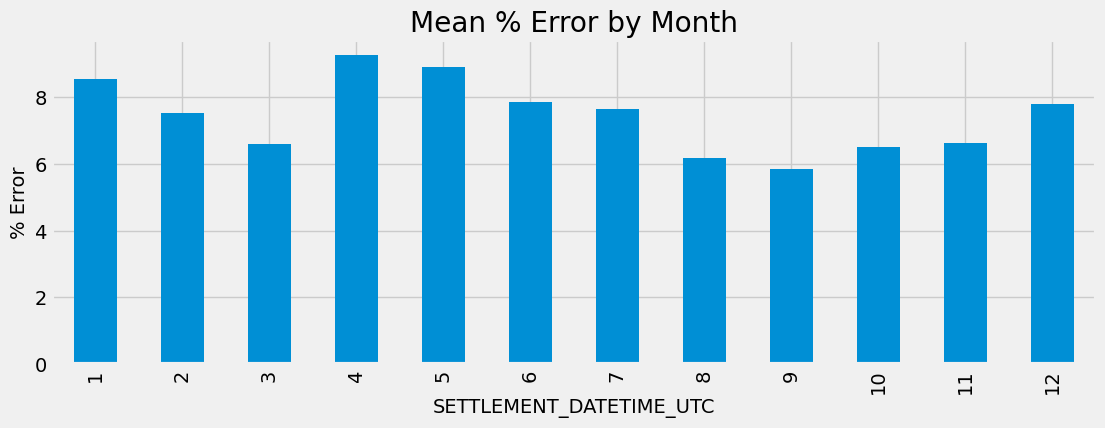

In [46]:
error_by_month = errors_df.groupby(errors_df.index.month).agg(
    mean_error=('error', 'mean'),
    mean_abs_error=('abs_error', 'mean'),
    mean_abs_pct_error=('abs_pct_error', 'mean')
)

error_by_month['mean_abs_pct_error'].plot(kind='bar', figsize=(12,4), title="Mean % Error by Month")
plt.ylabel('% Error'); plt.show()

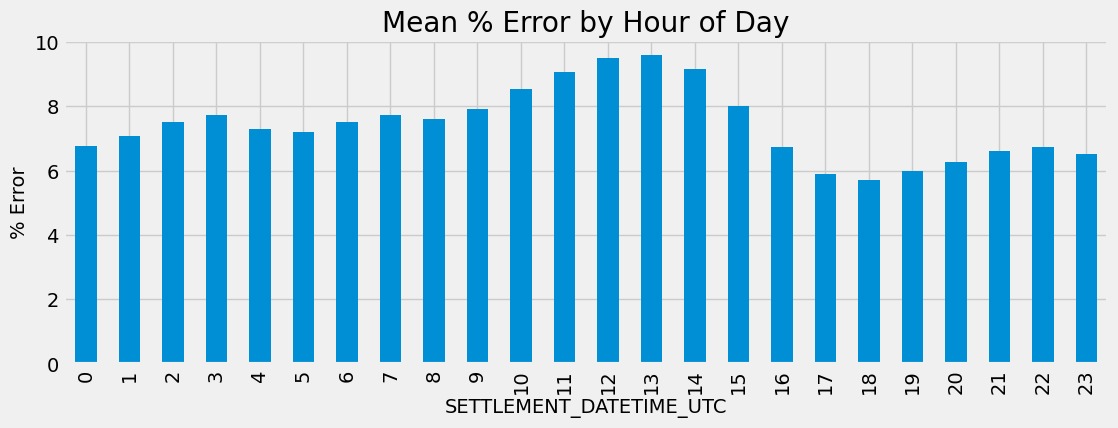

In [47]:
error_by_hour = errors_df.groupby(errors_df.index.hour).agg(
    mean_error=('error', 'mean'),
    mean_abs_error=('abs_error', 'mean'),
    mean_abs_pct_error=('abs_pct_error', 'mean')
)

error_by_hour['mean_abs_pct_error'].plot(kind='bar', figsize=(12,4), title="Mean % Error by Hour of Day")
plt.ylabel('% Error'); plt.show()

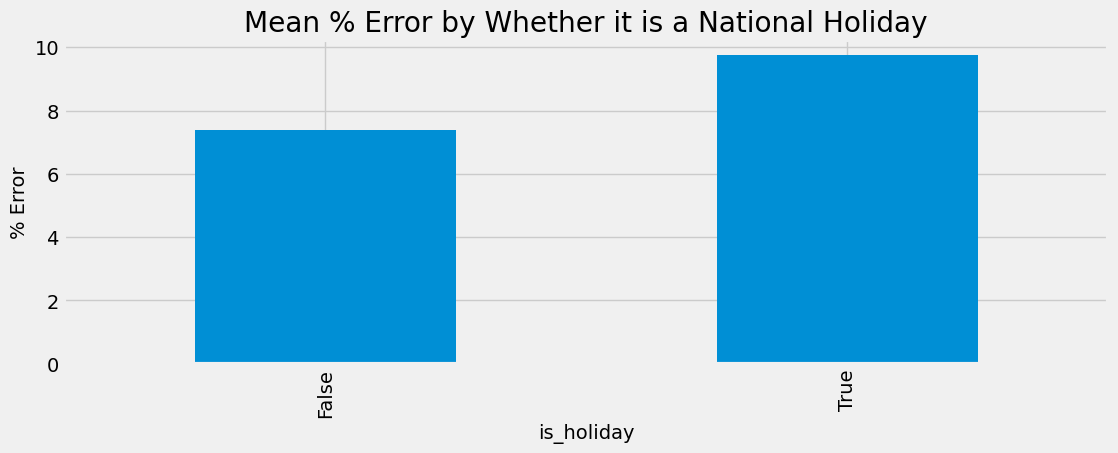

In [48]:
error_by_holiday = errors_df.groupby('is_holiday').agg(
    mean_error=('error', 'mean'),
    mean_abs_error=('abs_error', 'mean'),
    mean_abs_pct_error=('abs_pct_error', 'mean')
)

error_by_holiday['mean_abs_pct_error'].plot(kind='bar', figsize=(12,4), title="Mean % Error by Whether it is a National Holiday")
plt.ylabel('% Error'); plt.show()


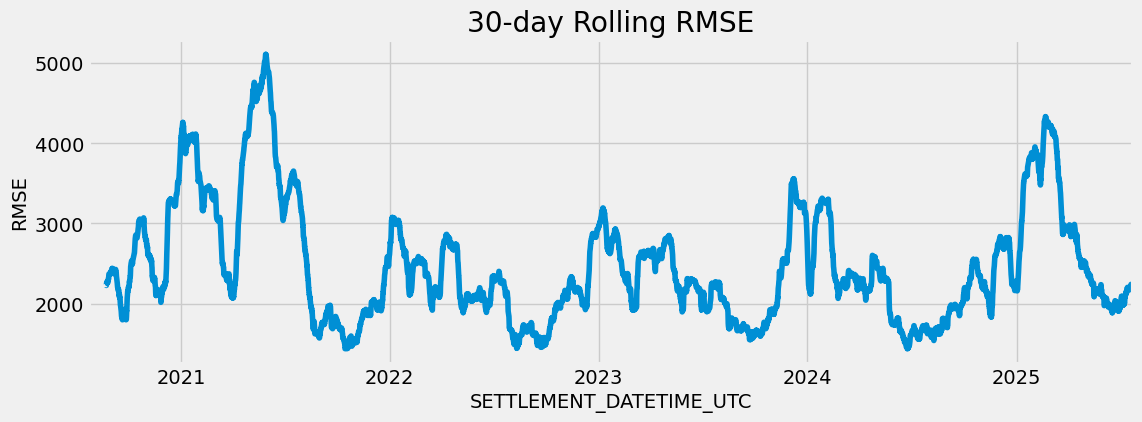

In [49]:
# residuals = actual - predicted
residuals = pred_df['ND'] - pred_df['prediction']

# --- Rolling RMSE ---
window_size = 48 * 30  # 30 days if half-hourly
rolling_rmse = (
    residuals
    .dropna()
    .rolling(window=window_size)
    .apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
)

rolling_rmse.plot(title='30-day Rolling RMSE', figsize=(12,4))
plt.ylabel('RMSE')
plt.show()

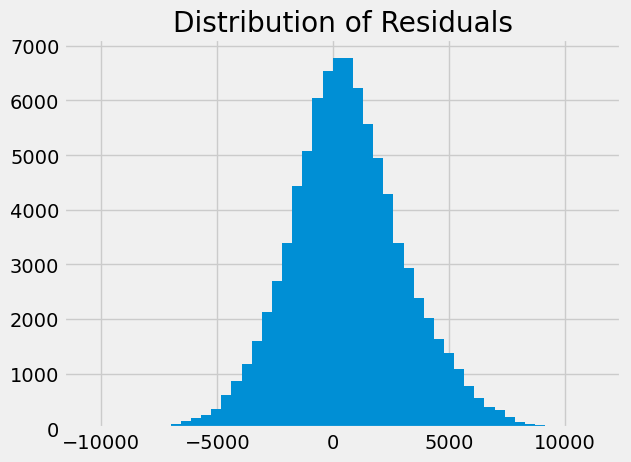

In [50]:
# --- Residual histogram ---
residuals.hist(bins=50)
plt.title("Distribution of Residuals")
plt.show()

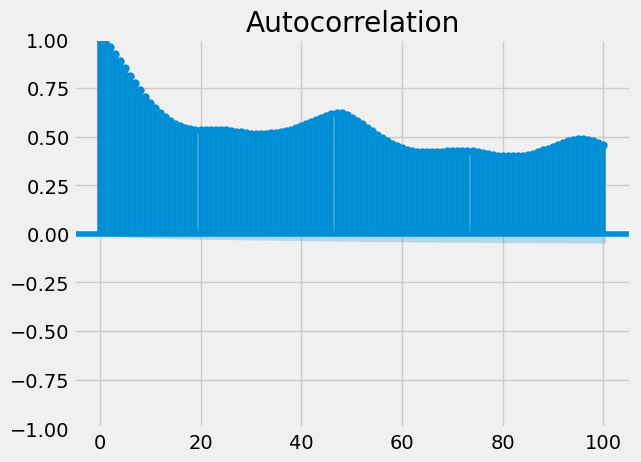

In [51]:
# --- Residual autocorrelation ---
plot_acf(residuals.dropna(), lags=100)
plt.show()

In [52]:
df.tail()

ND SETTLEMENT_DATETIME_LOCAL  IS_DST  hour  \
SETTLEMENT_DATETIME_UTC                                                    
2025-07-22 20:30:00+00:00  26499 2025-07-22 21:30:00+01:00       1    20   
2025-07-22 21:00:00+00:00  25492 2025-07-22 22:00:00+01:00       1    21   
2025-07-22 21:30:00+00:00  24543 2025-07-22 22:30:00+01:00       1    21   
2025-07-22 22:00:00+00:00  23637 2025-07-22 23:00:00+01:00       1    22   
2025-07-22 22:30:00+00:00  22323 2025-07-22 23:30:00+01:00       1    22   

                           minute  day_of_week  is_weekend  quarter  month  \
SETTLEMENT_DATETIME_UTC                                                      
2025-07-22 20:30:00+00:00      30            1       False        3      7   
2025-07-22 21:00:00+00:00       0            1       False        3      7   
2025-07-22 21:30:00+00:00      30            1       False        3      7   
2025-07-22 22:00:00+00:00       0            1       False        3      7   
2025-07-22 22:30:00+00:00      30            1       False        3      7   

                           year  ...    sp_sin    sp_cos  holiday_name  \
SETTLEMENT_DATETIME_UTC          ...                                     
2025-07-22 20:30:00+00:00  2025  ... -0.707107  0.707107          None   
2025-07-22 21:00:00+00:00  2025  ... -0.608761  0.793353          None   
2025-07-22 21:30:00+00:00  2025  ... -0.500000  0.866025          None   
2025-07-22 22:00:00+00:00  2025  ... -0.382683  0.923880          None   
2025-07-22 22:30:00+00:00  2025  ... -0.258819  0.965926          None   

                           is_holiday ND_exactly_1_years_ago  \
SETTLEMENT_DATETIME_UTC                                        
2025-07-22 20:30:00+00:00       False                26183.0   
2025-07-22 21:00:00+00:00       False                25126.0   
2025-07-22 21:30:00+00:00       False                24074.0   
2025-07-22 22:00:00+00:00       False                22979.0   
2025-07-22 22:30:00+00:00       False                22025.0   

                           ND_exactly_2_years_ago  ND_exactly_3_years_ago  \
SETTLEMENT_DATETIME_UTC                                                     
2025-07-22 20:30:00+00:00                 22617.0                 25698.0   
2025-07-22 21:00:00+00:00                 22061.0                 25162.0   
2025-07-22 21:30:00+00:00                 21031.0                 24267.0   
2025-07-22 22:00:00+00:00                 19793.0                 22701.0   
2025-07-22 22:30:00+00:00                 18805.0                 21713.0   

                          ND_exactly_4_years_ago  ND_exactly_5_years_ago  \
SETTLEMENT_DATETIME_UTC                                                    
2025-07-22 20:30:00+00:00                29685.0                 27142.0   
2025-07-22 21:00:00+00:00                28843.0                 26252.0   
2025-07-22 21:30:00+00:00                27720.0                 24987.0   
2025-07-22 22:00:00+00:00                26039.0                 23480.0   
2025-07-22 22:30:00+00:00                24609.0                 22184.0   

                             prediction  
SETTLEMENT_DATETIME_UTC                  
2025-07-22 20:30:00+00:00  24736.636719  
2025-07-22 21:00:00+00:00  23956.201172  
2025-07-22 21:30:00+00:00  22597.070312  
2025-07-22 22:00:00+00:00  21271.361328  
2025-07-22 22:30:00+00:00  20110.894531  

[5 rows x 25 columns]

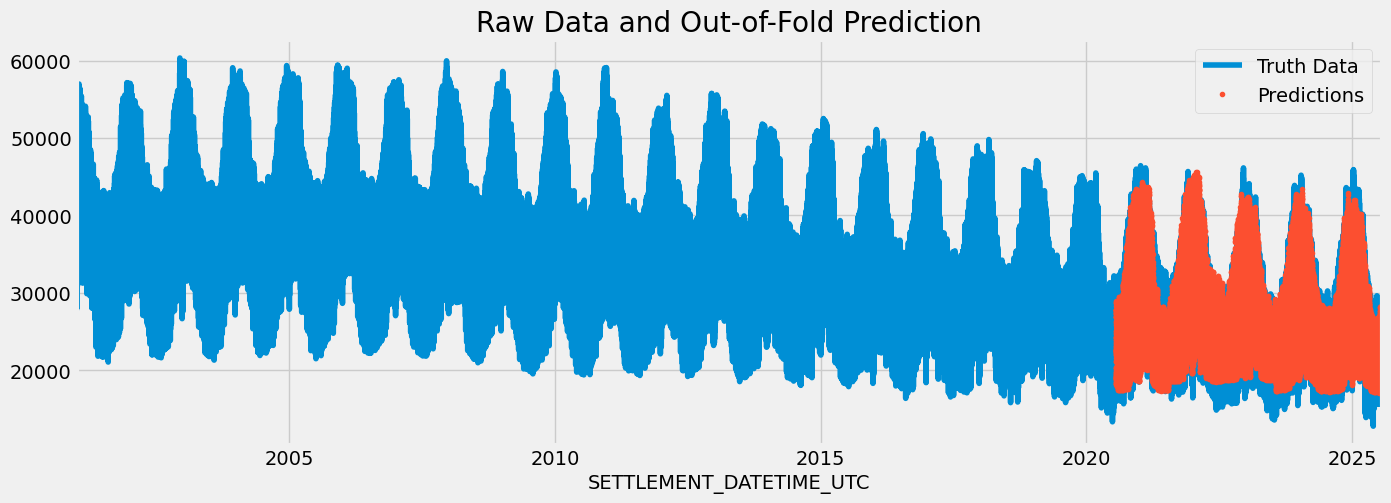

In [53]:
ax = df[['ND']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Out-of-Fold Prediction')
plt.show()

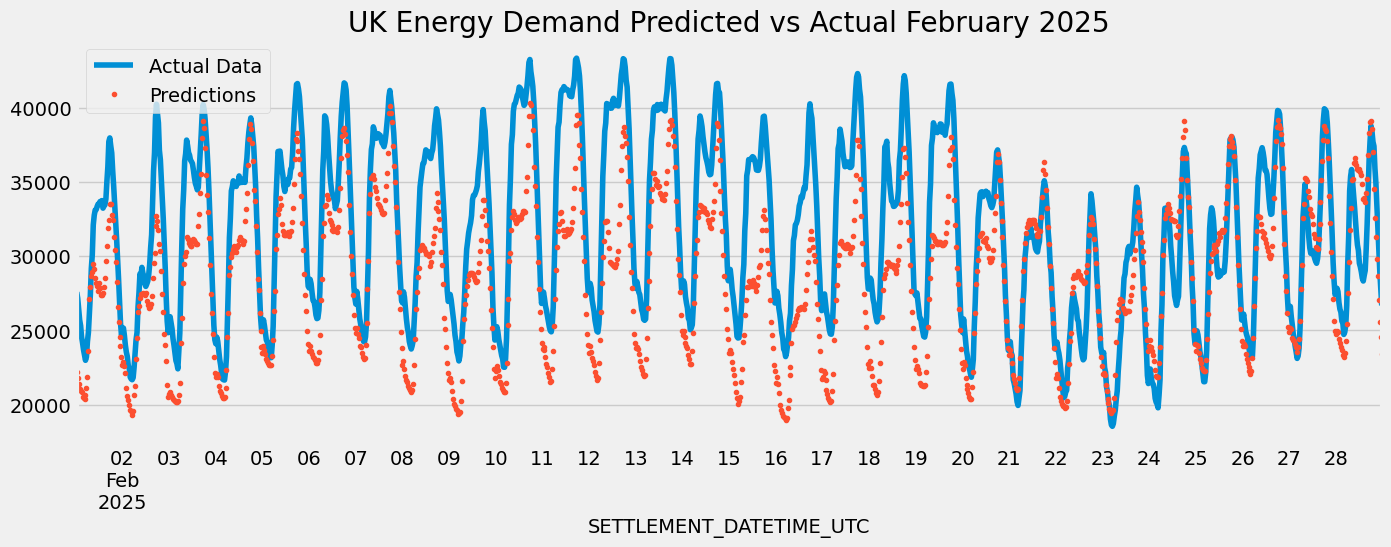

In [54]:
ax = df.loc[(df.index > '2025-02-01') & (df.index < '2025-03-01')]['ND'].plot(figsize=(15,5))
df.loc[(df.index > '2025-02-01') & (df.index < '2025-03-01')]['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('UK Energy Demand Predicted vs Actual February 2025')
plt.show()

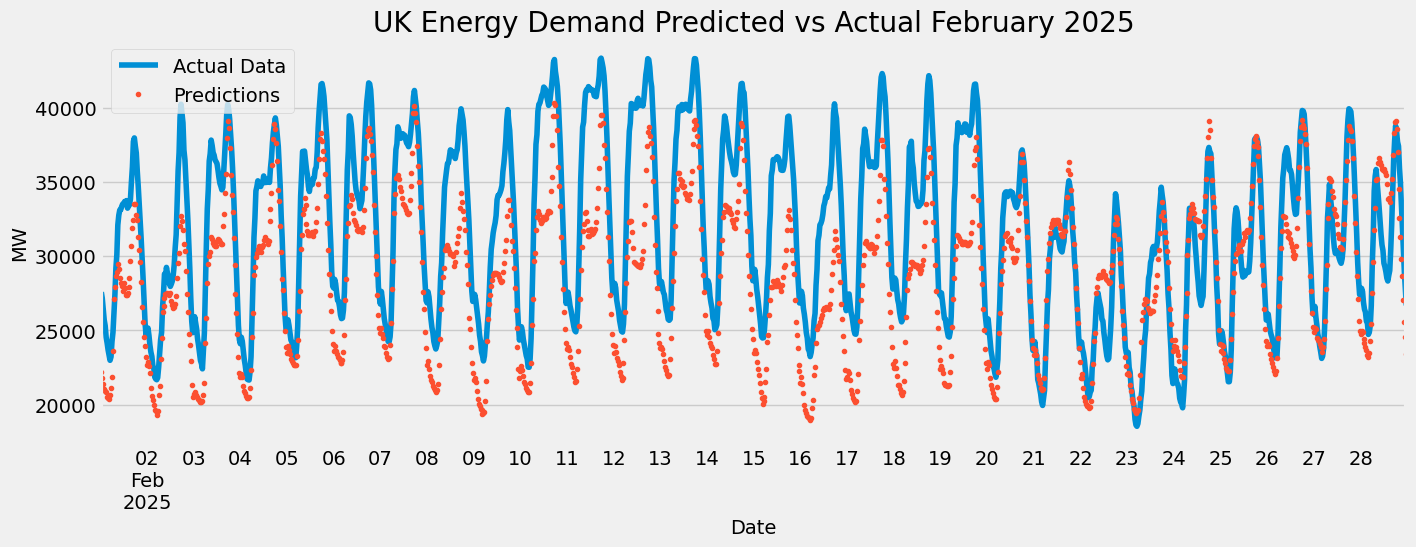

In [55]:
ax = df.loc[(df.index > '2025-02-01') & (df.index < '2025-03-01')]['ND'].plot(figsize=(15,5))
df.loc[(df.index > '2025-02-01') & (df.index < '2025-03-01')]['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('UK Energy Demand Predicted vs Actual February 2025')

# Add axis labels
ax.set_xlabel('Date')
ax.set_ylabel('MW')

plt.show()

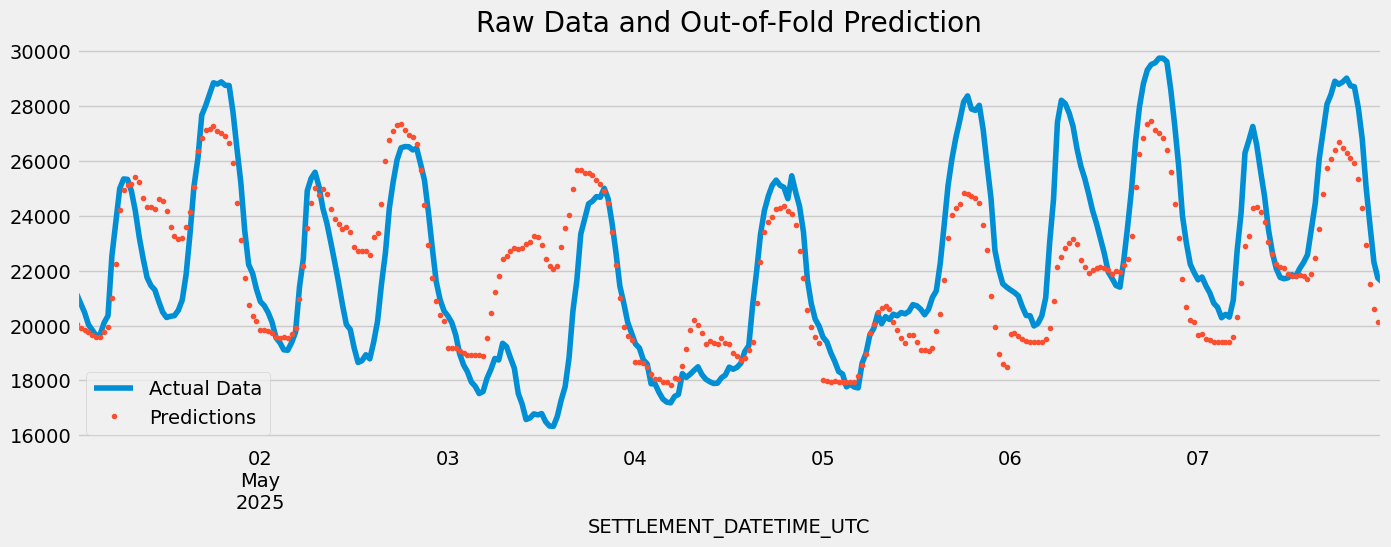

In [56]:
ax = df.loc[(df.index > '2025-05-01') & (df.index < '2025-05-08')]['ND'].plot(figsize=(15,5))
df.loc[(df.index > '2025-05-01') & (df.index < '2025-05-08')]['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Data and Out-of-Fold Prediction')
plt.show()

[Back to Contents](#Contents)

# 7. Predicting Future Energy Use

In [57]:
# keep freq + tz consistent with your history
freq = pd.infer_freq(df.index) or '30min'
step = pd.tseries.frequencies.to_offset(freq)

# start one step after your last observed timestamp
start = df.index.max() + step

# end exactly one calendar year after start (handles leap years & DST)
end = start + pd.DateOffset(years=1)

# build future timeline; exclude the end instant itself
future = pd.date_range(start=start, end=end, freq=freq, inclusive='left')

future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True

df = df.copy()
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])
df_and_future = create_calendar_features(df_and_future)
df_and_future = add_calendar_lags(df_and_future)

In [58]:
future_w_features = df_and_future.query('isFuture').copy()

In [59]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

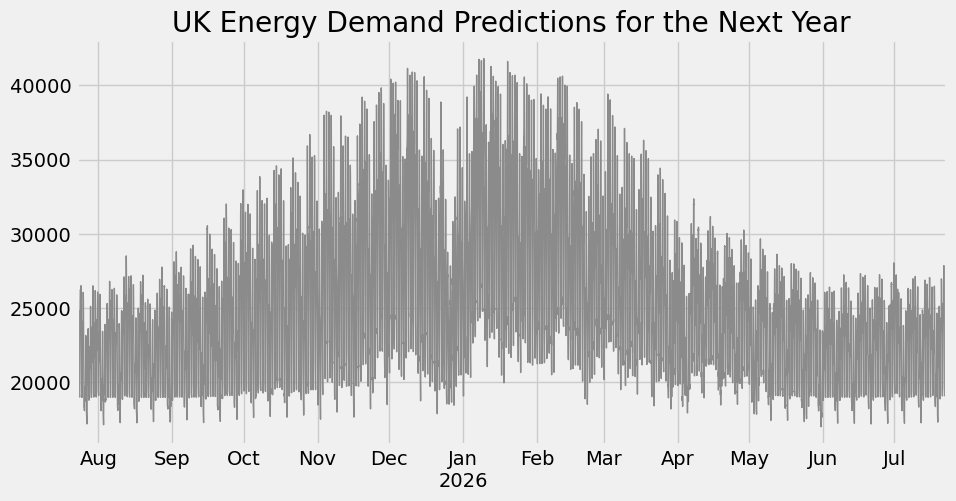

In [60]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='UK Energy Demand Predictions for the Next Year')
plt.show()

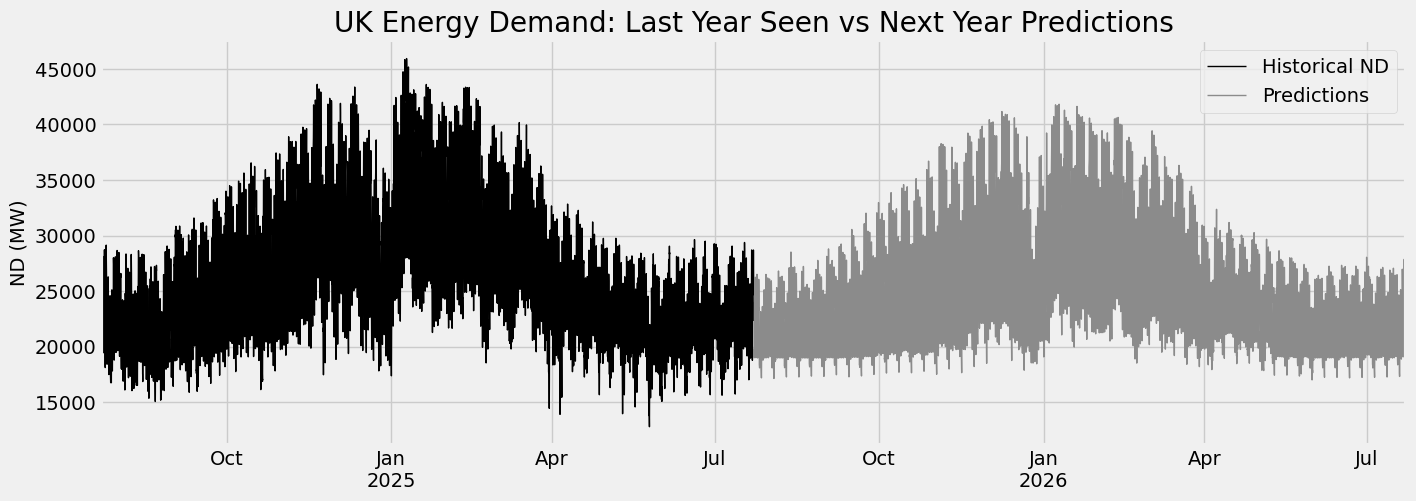

In [61]:
# 1) Get the last year of historical ND
last_year_start = df.index.max() - pd.DateOffset(years=1)
history_last_year = df.loc[last_year_start:].copy()

# 2) Combine with only the predictions for the future
plot_df = pd.concat([history_last_year[['ND']], future_w_features[['pred']]])

# 3) Plot
fig, ax = plt.subplots(figsize=(15, 5))

# Historical ND
plot_df['ND'].plot(ax=ax, color='black', lw=1, label='Historical ND')

# Future predictions
plot_df['pred'].plot(ax=ax, color=color_pal[4], lw=1, label='Predictions')

ax.set_title('UK Energy Demand: Last Year Seen vs Next Year Predictions')
ax.set_ylabel('ND (MW)')
ax.legend()
plt.show()

In [62]:
# --- Improvement 7: Residual-based Prediction Intervals ---

# 1) Compute residuals by settlement period (or month+sp for finer bands)
grp = errors_df.groupby('settlement_period')['error']

# 10th and 90th percentiles of errors
q_lo = grp.quantile(0.05)
q_hi = grp.quantile(0.95)

# 2) Apply to future predictions
sp_future = future_w_features['settlement_period']
future_w_features['pred_p05'] = future_w_features['pred'] + sp_future.map(q_lo).values
future_w_features['pred_p95'] = future_w_features['pred'] + sp_future.map(q_hi).values

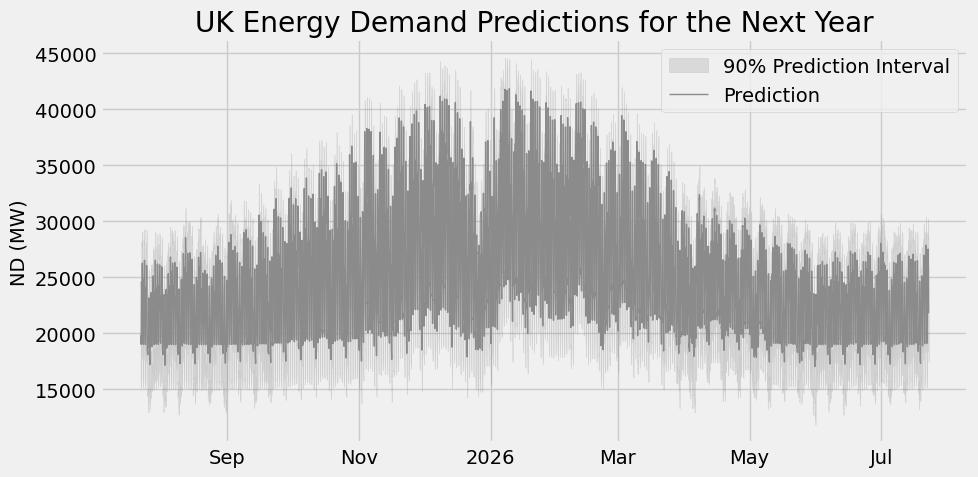

In [63]:
# 1) Keep only the rows where all three series exist
band = future_w_features[['pred', 'pred_p05', 'pred_p95']].dropna().copy()

# 2) Ensure index is sorted and timezone-naive (matplotlib is picky here)
band = band.sort_index()
if band.index.tz is not None:
    x = band.index.tz_convert(None).to_pydatetime()
else:
    x = band.index.to_pydatetime()

# 3) Make sure lower <= upper (swap if needed)
low  = np.minimum(band['pred_p05'].values, band['pred_p95'].values)
high = np.maximum(band['pred_p05'].values, band['pred_p95'].values)

# 4) Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Shaded interval
ax.fill_between(x, low, high, alpha=0.2, color='gray', label='90% Prediction Interval')

# Forecast line
ax.plot(x, band['pred'].values, lw=1, color=color_pal[4], label='Prediction')

# Nice date formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_title('UK Energy Demand Predictions for the Next Year')
ax.set_ylabel('ND (MW)')
ax.legend()
plt.tight_layout()
plt.show()

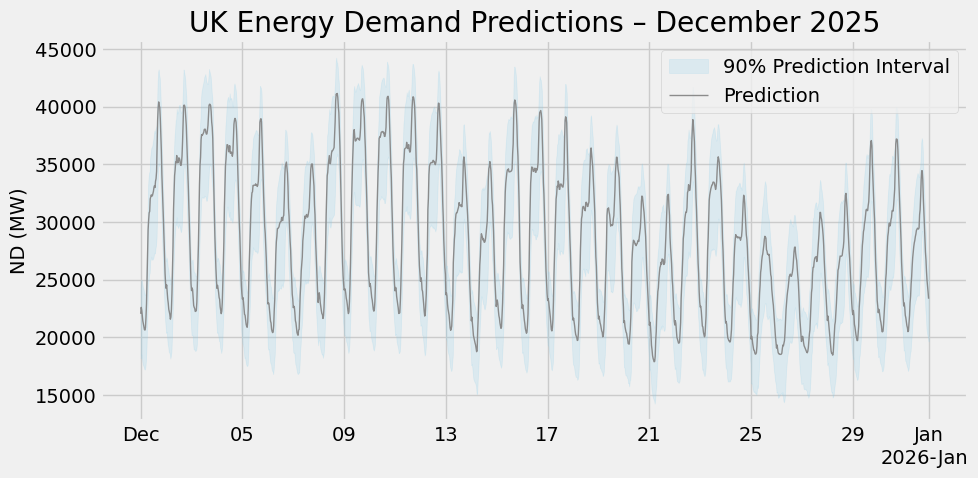

In [64]:
# Filter for December 2025
band = future_w_features[['pred', 'pred_p05', 'pred_p95']].dropna().copy()
band = band.loc['2025-12-01':'2025-12-31']

# Ensure index sorted and timezone-naive
band = band.sort_index()
if band.index.tz is not None:
    x = band.index.tz_convert(None).to_pydatetime()
else:
    x = band.index.to_pydatetime()

# Ensure lower <= upper
low  = np.minimum(band['pred_p05'].values, band['pred_p95'].values)
high = np.maximum(band['pred_p05'].values, band['pred_p95'].values)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Shaded interval
ax.fill_between(x, low, high, alpha=0.2, color='skyblue', label='90% Prediction Interval')

# Forecast line
ax.plot(x, band['pred'].values, lw=1, color=color_pal[4], label='Prediction')

# Date formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_title('UK Energy Demand Predictions – December 2025')
ax.set_ylabel('ND (MW)')
ax.legend()
plt.tight_layout()
plt.show()


[Back to Contents](#Contents)